## Fine-tunning RGB-DT

In [1]:
import sys
import random
sys.path.append("../")  # 프로젝트 루트를 경로에 추가
from model import create_model
from monai.losses import DiceLoss
import re 
import os
import math
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(2025)
torch.cuda.manual_seed_all(2025)

A new version of Albumentations is available: 2.0.0 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## 2. 모델 로드 및 Pretraining 체크포인트 로드

In [2]:
# Fine-tuning을 위한 UNet 모델 생성
unet_fine_model = create_model(
    model_type="custom_unet",
    in_channels=4,   # 입력 채널 수: RGB(3) + Depth(1) + Weak Texture Map(1)
    out_channels=2   # 출력 채널 수: Wrinkle(1) + Background(1)
)
print(unet_fine_model)

UNet(
  (input_block): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): Down(
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=

In [3]:
unet_fine_model = nn.DataParallel(unet_fine_model).cuda()

## 3. 데이터셋 정의

In [4]:
class CustomCosineAnnealingWarmRestarts(optim.lr_scheduler.CosineAnnealingWarmRestarts):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, eta_max=0.0001, decay_factor=0.9, start_epoch=0, last_epoch=-1):
        self.eta_max = eta_max
        self.decay_factor = decay_factor
        self.current_cycle = 0
        self.start_epoch = start_epoch  # 스케줄링 시작 epoch
        self.cycle_offset = 0  # warm restart 때마다 T_total을 더해 줄 변수
        super().__init__(optimizer, T_0, T_mult, eta_min, last_epoch)
    def get_lr(self):
        """
        현재 학습률 계산 (start_epoch 이전에는 기본 학습률 유지)
        """
        if self.last_epoch < self.start_epoch:
            # start_epoch 이전에는 기본 학습률 반환
            return [base_lr for base_lr in self.base_lrs]

        T_cur = self.T_cur
        T_total = self.T_0 * (self.T_mult ** self.current_cycle)  # 현재 주기의 전체 길이

        # Cosine Annealing 수식에 따라 학습률 계산
        return [
            self.eta_min + (self.eta_max - self.eta_min) *
            (1 + math.cos(math.pi * T_cur / T_total)) / 2
            for _ in self.base_lrs
        ]

    def step(self, epoch=None):
        """
        학습률 및 주기 갱신
        """
        if epoch is None:
            epoch = self.last_epoch + 1
        else:
            self.last_epoch = epoch

        if epoch < self.start_epoch:
            # start_epoch 이전에는 아무런 동작을 수행하지 않음
            self.last_epoch = epoch
            return
        
        effective_epoch = epoch - self.start_epoch

        # 주기 갱신 로직
        T_total = self.T_0 * (self.T_mult ** self.current_cycle)
        
        self.T_cur = effective_epoch - self.cycle_offset
        print(f"[DEBUG step] epoch={epoch}, effective_epoch={effective_epoch}, T_cur={self.T_cur}, T_total={T_total}, current_cycle={self.current_cycle}, eta_max={self.eta_max}")

        if self.T_cur >= T_total:
            self.current_cycle += 1
            self.eta_max *= self.decay_factor
            self.cycle_offset += T_total  # 지나간 주기 길이를 누적
            self.T_cur = 0
            print(f"[DEBUG step] Warm Restart triggered: current_cycle={self.current_cycle}, new eta_max={self.eta_max}")

        # 부모 클래스의 step 호출
        super().step(epoch)

        # 학습률 갱신
        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]
        print(f"[DEBUG step] After step: last_epoch={self.last_epoch}, T_cur={self.T_cur}, current_cycle={self.current_cycle}, _last_lr={self._last_lr}")

class WrinkleDataset(Dataset):
    def __init__(self, rgb_paths, depth_paths, weak_texture_paths, label_paths, transform=None, 
                 min_depth=55.0, max_depth=247.0, mode="RGBDT"):
        """
        Args:
            rgb_paths (str): RGB 이미지 경로.
            depth_paths (str): Depth 맵 경로.
            weak_texture_paths (str): Weak Texture Map 경로.
            label_paths (str): Masked Texture Map 경로.
            transform (callable, optional): 데이터 변환 함수.
            mode (str): 입력 모드 선택 ("RGB", "RGBD", "RGBT", "RGBDT").
        """
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.weak_texture_paths = weak_texture_paths  
        self.label_paths = label_paths
        self.transform = transform

        # RGB 이미지 정규화를 위한 평균과 표준편차
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        
        # Depth 이미지 정규화를 위한 최소값과 최대값
        self.min_depth = min_depth
        self.max_depth = max_depth

        # 입력 모드 설정
        self.mode = mode

    def __len__(self):
        return len(self.rgb_paths)

    def set_transform(self, transform):
        """
        데이터셋의 변환(transform)을 동적으로 변경하는 메서드.
        """
        self.transform = transform

    def __getitem__(self, idx):
        rgb_path = self.rgb_paths[idx]
        depth_path = self.depth_paths[idx]
        weak_texture_path = self.weak_texture_paths[idx]
        label_path = self.label_paths[idx]

        # RGB 로드 및 정규화
        rgb_image = np.array(Image.open(rgb_path).convert("RGB")).astype(np.float32) / 255.0

        # Depth 로드 및 정규화
        if "D" in self.mode:
            depth_image = np.array(Image.open(depth_path).convert("L")).astype(np.float32)
            depth_image = (depth_image - self.min_depth) / (self.max_depth - self.min_depth)
            depth_image = np.clip(depth_image, 0, 1)
            depth_image = np.expand_dims(depth_image, axis=-1)  # (H, W, 1)
        
        # Weak Texture 로드 및 정규화
        if "T" in self.mode:
            weak_texture_image = np.array(Image.open(weak_texture_path).convert("L")).astype(np.float32) / 255.0
            weak_texture_image = np.expand_dims(weak_texture_image, axis=-1)  # (H, W, 1)

        # 입력 데이터 생성
        input_image = rgb_image
        if "D" in self.mode:
            input_image = np.concatenate((input_image, depth_image), axis=-1)
        if "T" in self.mode:
            input_image = np.concatenate((input_image, weak_texture_image), axis=-1)

        # Label 로드 (클래스 인덱스)
        label = np.array(Image.open(label_path).convert("L")).astype(np.int64)  # 정수형으로 변환
        label = (label > 0.5).astype(np.int64)  # 이진화, threshold는 필요에 따라 조정

        # Transform 적용
        if self.transform:
            augmented = self.transform(image=input_image, mask=label)
            input_image = augmented['image']
            label = augmented['mask']
        else:
            # ToTensor 변환
            input_image = ToTensorV2()(image=input_image)['image']
            label = ToTensorV2()(image=label)['image']

        return input_image, label
"""
# 학습 및 검증 함수
def train_epoch(loader, model, criterion, optimizer, scaler):
    model.train()
    epoch_loss = 0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # Forward
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(loader, model, criterion, epoch, scaler, writer=None):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc="Validation")):
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward
            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # 일부 예측 결과 저장
            if batch_idx < 5 and writer is not None:
                save_pretraining_results(inputs, outputs, labels, epoch, batch_idx)
                
    return epoch_loss / len(loader)
"""
def calculate_metrics_gpu(y_true, y_pred):
    """
    GPU를 사용하여 JSI, F1-Score, Accuracy, Precision, Recall 계산.
    """
    # Flatten the tensors
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate TP, FP, FN, TN
    tp = ((y_pred == 1) & (y_true == 1)).sum().float()
    fp = ((y_pred == 1) & (y_true == 0)).sum().float()
    fn = ((y_pred == 0) & (y_true == 1)).sum().float()
    tn = ((y_pred == 0) & (y_true == 0)).sum().float()

    # JSI (IoU)
    jsi = tp / (tp + fp + fn + 1e-8)

    # Precision, Recall
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    # F1-Score
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)

    return jsi.item(), f1.item(), acc.item(), precision.item(), recall.item()

def train_epoch(loader, model, criterion, optimizer, scaler):
    model.train()
    epoch_loss = 0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # Forward
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def validate_epoch(loader, model, criterion, epoch, scaler, writer=None):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc="Validation")):
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward
            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            labels = labels.squeeze(1)
            all_preds.append(preds)
            all_labels.append(labels)

            # Save some predictions for visualization (차원 복구)
            if batch_idx < 5 and writer is not None:
                save_pretraining_results(inputs, outputs, labels, epoch, batch_idx)

        # Calculate metrics
    all_preds = torch.cat(all_preds, dim=0).cuda()
    all_labels = torch.cat(all_labels, dim=0).cuda()
    jsi, f1, acc, precision, recall = calculate_metrics_gpu(all_labels, all_preds)
    
    # Log metrics to TensorBoard
    if writer:
        writer.add_scalar('Metrics/JSI', jsi, epoch)
        writer.add_scalar('Metrics/F1-Score', f1, epoch)
        writer.add_scalar('Metrics/Accuracy', acc, epoch)
        writer.add_scalar('Metrics/Precision', precision, epoch)
        writer.add_scalar('Metrics/Recall', recall, epoch)

    # Return loss and metrics
    return epoch_loss / len(loader), jsi, f1


# 전체 Depth 이미지에서 최소값과 최대값 계산
def calculate_depth_min_max(depth_paths):
    min_depth = float('inf')
    max_depth = float('-inf')

    for depth_path in depth_paths:
        depth_image = np.array(Image.open(depth_path).convert("L")).astype(np.float32)
        min_depth = min(min_depth, depth_image.min())
        max_depth = max(max_depth, depth_image.max())

    return min_depth, max_depth


def save_pretraining_results(inputs, outputs, labels, epoch, batch_idx):
    # 배치에서 첫 번째 이미지 사용
    input_image = inputs[0].cpu().detach()
    output_image = outputs[0].cpu().detach()
    label_image = labels[0].cpu().detach()
    
    # 입력 이미지의 RGB 채널만 사용
    input_image_rgb = input_image[:3]  # [3, H, W]
    
    # 시각화를 위해 [0, 1] 범위로 스케일링
    input_image_rgb = (input_image_rgb - input_image_rgb.min()) / (input_image_rgb.max() - input_image_rgb.min())
    
    # 예측 마스크: torch.argmax을 사용하여 클래스 인덱스 추출
    pred_mask = torch.argmax(output_image, dim=0).float()  # [H, W]
    pred_mask = pred_mask.unsqueeze(0)  # [1, H, W]
    # 필요에 따라 스케일링 (이미 이진화된 경우 생략 가능)
    pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
    
    # 실제 마스크: 채널 차원 제거 후 채널 차원 추가
    true_mask = label_image.squeeze(0).float()  # [H, W]
    true_mask = true_mask.unsqueeze(0)  # [1, H, W]
    # 필요에 따라 스케일링 (이미 이진화된 경우 생략 가능)
    true_mask = (true_mask - true_mask.min()) / (true_mask.max() - true_mask.min())
    
    # TensorBoard에 이미지 추가
    writer.add_image(f'Validation/Input_Epoch_{epoch}_Batch_{batch_idx}', input_image_rgb, epoch)
    writer.add_image(f'Validation/Predicted_Epoch_{epoch}_Batch_{batch_idx}', pred_mask, epoch)
    writer.add_image(f'Validation/GroundTruth_Epoch_{epoch}_Batch_{batch_idx}', true_mask, epoch)

def save_model(model, optimizer, scheduler, epoch, best_val_loss, filepath='best_model_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }, filepath)
    print(f"Model saved to {filepath}")

## 4. Transform 및 Loss 정의

In [5]:
# Soft Dice Loss 정의
"""
class SoftDiceLoss(nn.Module):
    def forward(self, logits, targets):
        smooth = 1e-5
        # 로짓에 소프트맥스 적용
        logits = torch.softmax(logits, dim=1)
        # 타겟을 one-hot 인코딩
        targets = nn.functional.one_hot(targets.long(), num_classes=2).permute(0, 3, 1, 2).float()

        intersection = torch.sum(logits * targets)
        union = torch.sum(logits) + torch.sum(targets)
        dice_score = (2 * intersection + smooth) / (union + smooth)
        loss = 1 - dice_score

        return loss
"""

# 데이터 증강 함수 정의
def get_train_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.2),
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1), rotate=(-15, 15), shear=(-10, 10), p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.0, 0.0), std=(0.229, 0.224, 0.225, 1.0, 1.0)),  # RGB + Depth + Weak Texture
        ToTensorV2(transpose_mask=True)
    ])

## 5. 데이터 경로 설정 및 매칭

In [6]:
# 경로 설정
rgb_dir = "/home/donghwi/F_wrinkle_model_project/data/finetuning/masked_face_images"
depth_dir = "/home/donghwi/F_wrinkle_model_project/data/finetuning/depth_masking"
weak_texture_dir = "/home/donghwi/F_wrinkle_model_project/data/finetuning/weak_wrinkle_mask"
label_dir = "/home/donghwi/F_wrinkle_model_project/data/finetuning/manual_wrinkle_masks"

# 각 폴더 내의 png 파일 리스트 획득
rgb_paths = sorted(glob.glob(os.path.join(rgb_dir, "*.png")))
depth_paths = sorted(glob.glob(os.path.join(depth_dir, "*.png")))
weak_texture_paths = sorted(glob.glob(os.path.join(weak_texture_dir, "*.png")))
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.png")))

# 여기서는 파일명이 1:1로 매칭된다고 가정합니다.
# 만약 파일명이 동일하다면, zip으로 매칭 시킬 수 있습니다.
# 파일명으로 매칭해야 한다면, 파일명을 key로 sort하고 zip할 수도 있습니다.

# 예를 들어 파일명이 동일하다면 파일명 기준으로 정렬하는 로직:
rgb_paths = sorted(rgb_paths, key=lambda x: os.path.basename(x))
depth_paths = sorted(depth_paths, key=lambda x: os.path.basename(x))
weak_texture_paths = sorted(weak_texture_paths, key=lambda x: os.path.basename(x))
label_paths = sorted(label_paths, key=lambda x: os.path.basename(x))

# 이제 rgb_paths[i], depth_paths[i], weak_texture_paths[i], label_paths[i] 형태로 매칭됨
print("매칭된 데이터 개수:", len(rgb_paths), len(depth_paths), len(weak_texture_paths), len(label_paths))

for i in random.sample(range(len(rgb_paths)), 5):
    print("Index:", i)
    print("RGB:", os.path.basename(rgb_paths[i]))
    print("Depth:", os.path.basename(depth_paths[i]))
    print("Weak Texture:", os.path.basename(weak_texture_paths[i]))
    print("Label:", os.path.basename(label_paths[i]))
    print("-----")

매칭된 데이터 개수: 1000 1000 1000 1000
Index: 182
RGB: 03049.png
Depth: 03049.png
Weak Texture: 03049.png
Label: 03049.png
-----
Index: 564
RGB: 06170.png
Depth: 06170.png
Weak Texture: 06170.png
Label: 06170.png
-----
Index: 545
RGB: 06121.png
Depth: 06121.png
Weak Texture: 06121.png
Label: 06121.png
-----
Index: 405
RGB: 05123.png
Depth: 05123.png
Weak Texture: 05123.png
Label: 05123.png
-----
Index: 313
RGB: 04111.png
Depth: 04111.png
Weak Texture: 04111.png
Label: 04111.png
-----


## 6. 데이터셋 생성 및 분할

In [7]:
min_depth, max_depth = calculate_depth_min_max(depth_paths)
# min_depth, max_depth = 55.0, 247.0
print(f"Depth 이미지의 최소값: {min_depth}, 최대값: {max_depth}")

Depth 이미지의 최소값: 55.0, 최대값: 247.0


In [8]:
# 전체 데이터셋 생성
mode = "RGBT"  # 사용할 모드 지정

# 데이터셋 생성
dataset = WrinkleDataset(rgb_paths, depth_paths, weak_texture_paths, label_paths,
                         transform=None, min_depth=min_depth, max_depth=max_depth, mode=mode)

Dataset size: 1000
Input shape: torch.Size([4, 1024, 1024])
Label shape: torch.Size([1, 1024, 1024])
Input min, max: 0.0 1.0
Label min, max: 0 1
[DEBUG] Mode: RGBT
[DEBUG] Input image shape: torch.Size([4, 1024, 1024])
[DEBUG] Number of input channels: 4
[DEBUG] Number of input channels: 4
[DEBUG] RGB shape: (1024, 1024, 3)
[DEBUG] Depth channel is None
[DEBUG] Weak Texture channel selected


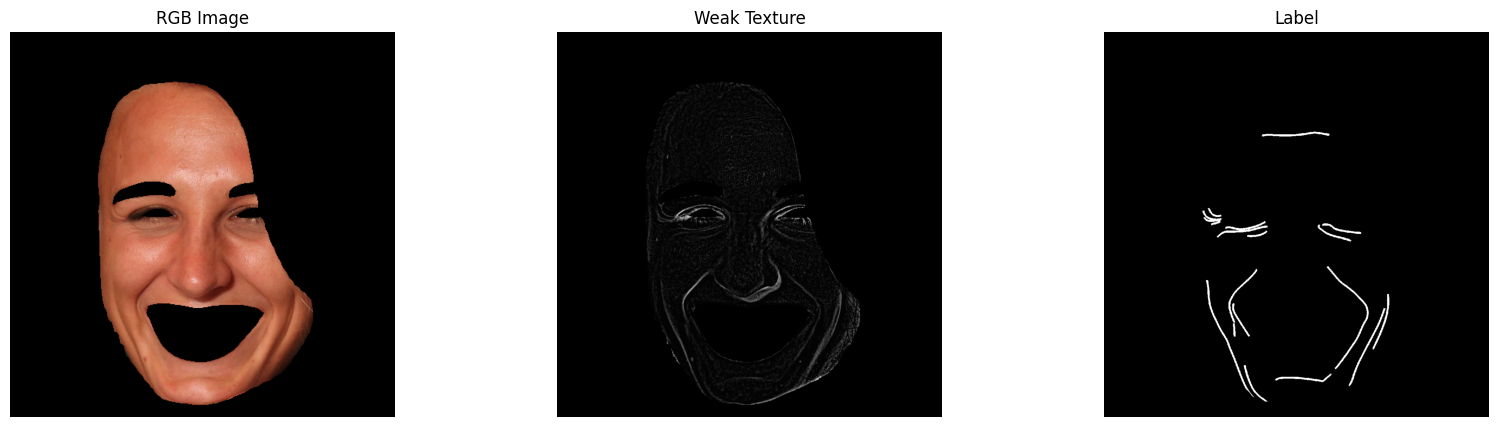

In [9]:
# 데이터셋 크기 확인
print("Dataset size:", len(dataset))

# 샘플 인덱스 선택
idx = 0
input_image, label = dataset[idx]

print("Input shape:", input_image.shape)  # 입력 데이터의 형태
print("Label shape:", label.shape)

print("Input min, max:", input_image.min().item(), input_image.max().item())
print("Label min, max:", label.min().item(), label.max().item())

# 디버그 메시지: 모드와 채널 수 확인
print(f"[DEBUG] Mode: {mode}")
print(f"[DEBUG] Input image shape: {input_image.shape}")

# 입력 채널 수 확인 및 시각화 준비
num_channels = input_image.shape[0]  # 실제 채널 수
print(f"[DEBUG] Number of input channels: {num_channels}")

# 입력 채널 수 확인 및 시각화 준비
num_channels = input_image.shape[0]  # 실제 채널 수
print(f"[DEBUG] Number of input channels: {num_channels}")

rgb = input_image[:3]  # (3, H, W)
depth = input_image[3] if num_channels > 3 and "D" in mode else None  # (H, W)
weak_texture = input_image[3] if num_channels > 3 and "T" in mode and "D" not in mode else \
               input_image[4] if num_channels > 4 and "T" in mode else None  # (H, W)


# 텐서를 NumPy로 변환 (시각화를 위해)
rgb_np = rgb.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
depth_np = depth.cpu().numpy() if depth is not None else None  # (H, W)
weak_texture_np = weak_texture.cpu().numpy() if weak_texture is not None else None  # (H, W)
label_np = label.squeeze().cpu().numpy()  # (H, W)

# 디버그 메시지: 각 채널 상태
print(f"[DEBUG] RGB shape: {rgb_np.shape}")
# 디버그 메시지: 채널 매핑 상태
if depth is not None:
    print(f"[DEBUG] Depth channel selected from input_image[3]")
else:
    print("[DEBUG] Depth channel is None")

if weak_texture is not None:
    print(f"[DEBUG] Weak Texture channel selected")
else:
    print("[DEBUG] Weak Texture channel is None")


# 출력할 이미지 수 계산
num_images = 1 + sum([depth is not None, weak_texture is not None]) + 1  # RGB, (Depth), (Weak Texture), Label

# 시각화
fig, axs = plt.subplots(1, num_images, figsize=(20, 5))

# RGB 이미지 출력
axs[0].imshow(rgb_np)
axs[0].set_title("RGB Image")
axs[0].axis('off')

# Depth 출력 (있는 경우)
if depth_np is not None:
    axs[1].imshow(depth_np, cmap='gray')
    axs[1].set_title("Depth")
    axs[1].axis('off')

# Weak Texture 출력 (있는 경우)
if weak_texture_np is not None:
    axs[1 + (depth_np is not None)].imshow(weak_texture_np, cmap='gray')
    axs[1 + (depth_np is not None)].set_title("Weak Texture")
    axs[1 + (depth_np is not None)].axis('off')

# Label 출력
axs[-1].imshow(label_np, cmap='gray')
axs[-1].set_title("Label")
axs[-1].axis('off')

plt.show()


In [10]:
class WrappedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        try:
            # 데이터셋에서 이미지와 레이블을 로드합니다.
            image, label = self.subset[idx]

            # print(f"Original label shape: {label.shape}")  # 디버깅 로그
            
            # 이미지가 torch.Tensor인 경우, numpy 배열로 변환
            if isinstance(image, torch.Tensor):
                image = image.cpu().numpy()
                # 채널 순서를 (C, H, W)에서 (H, W, C)로 변경
                image = np.transpose(image, (1, 2, 0))
            
            # 레이블이 torch.Tensor인 경우, numpy 배열로 변환
            if isinstance(label, torch.Tensor):
                label = label.cpu().numpy()
                # 채널 순서를 (C, H, W)에서 (H, W, C)로 변경
                label = np.transpose(label, (1, 2, 0))
            
            # 이미지와 레이블이 PIL Image인 경우, numpy 배열로 변환
            if isinstance(image, Image.Image):
                image = np.array(image)
            
            if isinstance(label, Image.Image):
                label = np.array(label)

            # print(f"Label shape before transform: {label.shape}")  # 디버깅 로그
            
            # albumentations 변환 적용
            if self.transform:
                augmented = self.transform(image=image, mask=label)
                image = augmented['image']
                label = augmented['mask']

            # print(f"Label shape after transform: {label.shape}")  # 디버깅 로그
            
            # 레이블이 다중 채널인 경우, 단일 채널로 변환
            if isinstance(label, torch.Tensor):
                if label.shape[0] > 1:
                    # 다중 채널을 단일 채널로 변환 (예: argmax 사용)
                    label = torch.argmax(label, dim=0).unsqueeze(0)
                else:
                    label = label.squeeze(0).unsqueeze(0)
            elif isinstance(label, np.ndarray):
                if label.ndim == 3 and label.shape[2] > 1:
                    label = np.argmax(label, axis=2)
                elif label.ndim == 3 and label.shape[2] == 1:
                    label = label.squeeze(2)
                elif label.ndim == 2:
                    pass  # 이미 single-channel
                else:
                    raise ValueError(f"Unexpected label shape: {label.shape}")
                label = torch.from_numpy(label).unsqueeze(0).long()
            else:
                raise ValueError(f"Unexpected label type: {type(label)}")

            # print(f"Final label shape: {label.shape}")  # 디버깅 로그
            
            return image, label
        except Exception as e:
            print(f"Error in __getitem__ for index {idx}: {e}")
            raise e
# 랜덤 시드 고정
generator = torch.Generator().manual_seed(42)

# 데이터셋 분할 (8:1:1)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_subset, val_subset, test_subset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

print(f"Train 데이터 개수: {len(train_subset)}")
print(f"Validation 데이터 개수: {len(val_subset)}")
print(f"Test 데이터 개수: {len(test_subset)}")

Train 데이터 개수: 800
Validation 데이터 개수: 100
Test 데이터 개수: 100


In [11]:
# transform 설정
train_transform = get_train_augmentations()
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.0, 0.0), std=(0.229, 0.224, 0.225, 1.0, 1.0)),
    ToTensorV2(transpose_mask=True)
])

# DataLoader 생성
batch_size = 8

# WrappedDataset으로 감싸서 각 서브셋에 별도의 변환 적용
train_dataset = WrappedDataset(train_subset, transform=train_transform)
val_dataset = WrappedDataset(val_subset, transform=val_transform)
test_dataset = WrappedDataset(test_subset, transform=val_transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 손실 함수 및 옵티마이저 정의
# criterion = SoftDiceLoss() # DiceLoss
criterion = DiceLoss(to_onehot_y=True, softmax=True, include_background=True)
# criterion = nn.MSELoss()  # pretraine loss function Mean Squared Error (MSE)
optimizer = optim.AdamW(
    unet_fine_model.parameters(),   # 모델의 학습 가능한 파라미터
    lr=0.0001,             # 학습률
    weight_decay=0.05,    # Weight Decay (L2 Regularization)
    betas=(0.9, 0.999)    # β1=0.9, β2=0.999
)

# 스케줄러 설정 (U-Net)
scheduler = CustomCosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=50,         # 초기 주기 길이
    T_mult=2,       # 주기 길이 배수
    eta_min=0,      # 최소 학습률
    eta_max=0.0001, # 초기 최대 학습률
    decay_factor=0.9,  # 최대 학습률 감소 비율
    start_epoch= 0
)

[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[0.0001]


In [12]:
# 학습 루프
scaler = GradScaler()
writer = SummaryWriter('unet_runs/unet_fintuning_RGBT_no2')
best_val_loss_unet = float('inf')
best_val_jsi = 0.0
patience = 15      # Early Stopping patience
patience_counter = 0
epochs = 150

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_epoch(train_loader, unet_fine_model, criterion, optimizer, scaler)
    # Validation
    val_loss, val_jsi, val_f1 = validate_epoch(val_loader, unet_fine_model, criterion, epoch + 1, scaler, writer)

    scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: LR={current_lr:.8f}, TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}")

    print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    print(f"Val JSI: {val_jsi:.6f}, Val F1-Score: {val_f1:.6f}")
    
    writer.add_scalar('Loss/Train', train_loss, epoch + 1)
    writer.add_scalar('Loss/Validation', val_loss, epoch + 1)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch + 1)

    # 모델 저장 기준 변경
    if val_jsi > best_val_jsi and val_loss < best_val_loss_unet:
        best_val_loss_unet = val_loss
        best_val_jsi = val_jsi
        save_model(unet_fine_model, optimizer, scheduler, epoch + 1, best_val_loss_unet, './no_RDT/best_unet_finetuning_RGBT_no2.pth')
        print(f"Model saved based on Validation JSI: {val_jsi:.4f} and Loss: {val_loss:.6f}")
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        print(f"No improvement. Patience counter: {patience_counter}/{patience}")
    """
    # Early Stopping
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    """
    torch.cuda.empty_cache()

# 학습 종료 메시지
if patience_counter >= patience:
    print("Training stopped early due to Early Stopping.")
else:
    print("Training completed successfully.")

writer.close()
print("Finetuning Completed.")

Epoch 1/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[0.0001]
Epoch 1: LR=0.00010000, TrainLoss=0.5485, ValLoss=0.5416
Train Loss: 0.548469, Val Loss: 0.541562
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 1/15
Epoch 2/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=1, effective_epoch=1, T_cur=1, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=1, T_cur=1, current_cycle=0, _last_lr=[9.990133642141359e-05]
Epoch 2: LR=0.00009990, TrainLoss=0.5103, ValLoss=0.6018
Train Loss: 0.510331, Val Loss: 0.601758
Val JSI: 0.000150, Val F1-Score: 0.000299
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.0001 and Loss: 0.601758
Epoch 3/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=2, effective_epoch=2, T_cur=2, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=2, T_cur=2, current_cycle=0, _last_lr=[9.96057350657239e-05]
Epoch 3: LR=0.00009961, TrainLoss=0.4845, ValLoss=0.6900
Train Loss: 0.484493, Val Loss: 0.690019
Val JSI: 0.005669, Val F1-Score: 0.011274
No improvement. Patience counter: 1/15
Epoch 4/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


[DEBUG step] epoch=3, effective_epoch=3, T_cur=3, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=3, T_cur=3, current_cycle=0, _last_lr=[9.911436253643445e-05]
Epoch 4: LR=0.00009911, TrainLoss=0.4623, ValLoss=0.5521
Train Loss: 0.462264, Val Loss: 0.552051
Val JSI: 0.002110, Val F1-Score: 0.004212
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.0021 and Loss: 0.552051
Epoch 5/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=4, effective_epoch=4, T_cur=4, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=4, T_cur=4, current_cycle=0, _last_lr=[9.842915805643155e-05]
Epoch 5: LR=0.00009843, TrainLoss=0.4408, ValLoss=0.8652
Train Loss: 0.440780, Val Loss: 0.865156
Val JSI: 0.007092, Val F1-Score: 0.014084
No improvement. Patience counter: 1/15
Epoch 6/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=5, effective_epoch=5, T_cur=5, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=5, T_cur=5, current_cycle=0, _last_lr=[9.755282581475769e-05]
Epoch 6: LR=0.00009755, TrainLoss=0.4225, ValLoss=0.5125
Train Loss: 0.422526, Val Loss: 0.512549
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 2/15
Epoch 7/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=6, effective_epoch=6, T_cur=6, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=6, T_cur=6, current_cycle=0, _last_lr=[9.648882429441257e-05]
Epoch 7: LR=0.00009649, TrainLoss=0.3993, ValLoss=0.5039
Train Loss: 0.399291, Val Loss: 0.503934
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 3/15
Epoch 8/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=7, effective_epoch=7, T_cur=7, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=7, T_cur=7, current_cycle=0, _last_lr=[9.524135262330098e-05]
Epoch 8: LR=0.00009524, TrainLoss=0.3780, ValLoss=0.5041
Train Loss: 0.378009, Val Loss: 0.504061
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 4/15
Epoch 9/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=8, effective_epoch=8, T_cur=8, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=8, T_cur=8, current_cycle=0, _last_lr=[9.381533400219318e-05]
Epoch 9: LR=0.00009382, TrainLoss=0.3654, ValLoss=0.5044
Train Loss: 0.365391, Val Loss: 0.504381
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 5/15
Epoch 10/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=9, effective_epoch=9, T_cur=9, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=9, T_cur=9, current_cycle=0, _last_lr=[9.221639627510076e-05]
Epoch 10: LR=0.00009222, TrainLoss=0.3459, ValLoss=0.5009
Train Loss: 0.345871, Val Loss: 0.500899
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 6/15
Epoch 11/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=10, effective_epoch=10, T_cur=10, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=10, T_cur=10, current_cycle=0, _last_lr=[9.045084971874738e-05]
Epoch 11: LR=0.00009045, TrainLoss=0.2804, ValLoss=0.5006
Train Loss: 0.280395, Val Loss: 0.500647
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 7/15
Epoch 12/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=11, effective_epoch=11, T_cur=11, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=11, T_cur=11, current_cycle=0, _last_lr=[8.852566213878947e-05]
Epoch 12: LR=0.00008853, TrainLoss=0.2613, ValLoss=0.5013
Train Loss: 0.261344, Val Loss: 0.501277
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 8/15
Epoch 13/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


[DEBUG step] epoch=12, effective_epoch=12, T_cur=12, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=12, T_cur=12, current_cycle=0, _last_lr=[8.644843137107059e-05]
Epoch 13: LR=0.00008645, TrainLoss=0.2474, ValLoss=0.5013
Train Loss: 0.247436, Val Loss: 0.501276
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 9/15
Epoch 14/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=13, effective_epoch=13, T_cur=13, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=13, T_cur=13, current_cycle=0, _last_lr=[8.422735529643444e-05]
Epoch 14: LR=0.00008423, TrainLoss=0.2417, ValLoss=0.5015
Train Loss: 0.241719, Val Loss: 0.501490
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 10/15
Epoch 15/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=14, effective_epoch=14, T_cur=14, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=14, T_cur=14, current_cycle=0, _last_lr=[8.18711994874345e-05]
Epoch 15: LR=0.00008187, TrainLoss=0.2337, ValLoss=0.5010
Train Loss: 0.233667, Val Loss: 0.500968
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 11/15
Epoch 16/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=15, effective_epoch=15, T_cur=15, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=15, T_cur=15, current_cycle=0, _last_lr=[7.938926261462367e-05]
Epoch 16: LR=0.00007939, TrainLoss=0.2281, ValLoss=0.5011
Train Loss: 0.228132, Val Loss: 0.501128
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 12/15
Epoch 17/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=16, effective_epoch=16, T_cur=16, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=16, T_cur=16, current_cycle=0, _last_lr=[7.679133974894983e-05]
Epoch 17: LR=0.00007679, TrainLoss=0.2246, ValLoss=0.5016
Train Loss: 0.224577, Val Loss: 0.501588
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 13/15
Epoch 18/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=17, effective_epoch=17, T_cur=17, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=17, T_cur=17, current_cycle=0, _last_lr=[7.408768370508576e-05]
Epoch 18: LR=0.00007409, TrainLoss=0.2236, ValLoss=0.5017
Train Loss: 0.223595, Val Loss: 0.501671
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 14/15
Epoch 19/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=18, effective_epoch=18, T_cur=18, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=18, T_cur=18, current_cycle=0, _last_lr=[7.128896457825364e-05]
Epoch 19: LR=0.00007129, TrainLoss=0.2174, ValLoss=0.5016
Train Loss: 0.217363, Val Loss: 0.501605
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 15/15
Epoch 20/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=19, effective_epoch=19, T_cur=19, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=19, T_cur=19, current_cycle=0, _last_lr=[6.840622763423391e-05]
Epoch 20: LR=0.00006841, TrainLoss=0.2166, ValLoss=0.5017
Train Loss: 0.216631, Val Loss: 0.501734
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 16/15
Epoch 21/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=20, effective_epoch=20, T_cur=20, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=20, T_cur=20, current_cycle=0, _last_lr=[6.545084971874738e-05]
Epoch 21: LR=0.00006545, TrainLoss=0.2135, ValLoss=0.5017
Train Loss: 0.213513, Val Loss: 0.501706
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 17/15
Epoch 22/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=21, effective_epoch=21, T_cur=21, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=21, T_cur=21, current_cycle=0, _last_lr=[6.243449435824273e-05]
Epoch 22: LR=0.00006243, TrainLoss=0.2127, ValLoss=0.5016
Train Loss: 0.212656, Val Loss: 0.501605
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 18/15
Epoch 23/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=22, effective_epoch=22, T_cur=22, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=22, T_cur=22, current_cycle=0, _last_lr=[5.9369065729286245e-05]
Epoch 23: LR=0.00005937, TrainLoss=0.2117, ValLoss=0.5016
Train Loss: 0.211682, Val Loss: 0.501621
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 19/15
Epoch 24/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=23, effective_epoch=23, T_cur=23, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=23, T_cur=23, current_cycle=0, _last_lr=[5.626666167821523e-05]
Epoch 24: LR=0.00005627, TrainLoss=0.2084, ValLoss=0.4995
Train Loss: 0.208446, Val Loss: 0.499528
Val JSI: 0.003072, Val F1-Score: 0.006125
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.0031 and Loss: 0.499528
Epoch 25/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=24, effective_epoch=24, T_cur=24, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=24, T_cur=24, current_cycle=0, _last_lr=[5.313952597646568e-05]
Epoch 25: LR=0.00005314, TrainLoss=0.2068, ValLoss=0.4939
Train Loss: 0.206785, Val Loss: 0.493881
Val JSI: 0.011748, Val F1-Score: 0.023223
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.0117 and Loss: 0.493881
Epoch 26/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=25, effective_epoch=25, T_cur=25, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=25, T_cur=25, current_cycle=0, _last_lr=[5e-05]
Epoch 26: LR=0.00005000, TrainLoss=0.2040, ValLoss=0.4241
Train Loss: 0.204045, Val Loss: 0.424092
Val JSI: 0.107607, Val F1-Score: 0.194306
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.1076 and Loss: 0.424092
Epoch 27/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=26, effective_epoch=26, T_cur=26, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=26, T_cur=26, current_cycle=0, _last_lr=[4.6860474023534335e-05]
Epoch 27: LR=0.00004686, TrainLoss=0.2026, ValLoss=0.5013
Train Loss: 0.202635, Val Loss: 0.501262
Val JSI: 0.000945, Val F1-Score: 0.001888
No improvement. Patience counter: 1/15
Epoch 28/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=27, effective_epoch=27, T_cur=27, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=27, T_cur=27, current_cycle=0, _last_lr=[4.3733338321784795e-05]
Epoch 28: LR=0.00004373, TrainLoss=0.2014, ValLoss=0.5017
Train Loss: 0.201433, Val Loss: 0.501746
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 2/15
Epoch 29/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=28, effective_epoch=28, T_cur=28, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=28, T_cur=28, current_cycle=0, _last_lr=[4.0630934270713774e-05]
Epoch 29: LR=0.00004063, TrainLoss=0.2008, ValLoss=0.5017
Train Loss: 0.200800, Val Loss: 0.501748
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 3/15
Epoch 30/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=29, effective_epoch=29, T_cur=29, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=29, T_cur=29, current_cycle=0, _last_lr=[3.756550564175726e-05]
Epoch 30: LR=0.00003757, TrainLoss=0.1983, ValLoss=0.4230
Train Loss: 0.198297, Val Loss: 0.422982
Val JSI: 0.105321, Val F1-Score: 0.190571
No improvement. Patience counter: 4/15
Epoch 31/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=30, effective_epoch=30, T_cur=30, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=30, T_cur=30, current_cycle=0, _last_lr=[3.454915028125264e-05]
Epoch 31: LR=0.00003455, TrainLoss=0.1963, ValLoss=0.5017
Train Loss: 0.196250, Val Loss: 0.501749
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 5/15
Epoch 32/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=31, effective_epoch=31, T_cur=31, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=31, T_cur=31, current_cycle=0, _last_lr=[3.159377236576612e-05]
Epoch 32: LR=0.00003159, TrainLoss=0.1949, ValLoss=0.5018
Train Loss: 0.194888, Val Loss: 0.501751
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 6/15
Epoch 33/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=32, effective_epoch=32, T_cur=32, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=32, T_cur=32, current_cycle=0, _last_lr=[2.8711035421746367e-05]
Epoch 33: LR=0.00002871, TrainLoss=0.1936, ValLoss=0.5018
Train Loss: 0.193570, Val Loss: 0.501753
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 7/15
Epoch 34/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=33, effective_epoch=33, T_cur=33, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=33, T_cur=33, current_cycle=0, _last_lr=[2.591231629491423e-05]
Epoch 34: LR=0.00002591, TrainLoss=0.1923, ValLoss=0.5017
Train Loss: 0.192343, Val Loss: 0.501749
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 8/15
Epoch 35/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=34, effective_epoch=34, T_cur=34, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=34, T_cur=34, current_cycle=0, _last_lr=[2.3208660251050158e-05]
Epoch 35: LR=0.00002321, TrainLoss=0.1915, ValLoss=0.5018
Train Loss: 0.191506, Val Loss: 0.501773
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 9/15
Epoch 36/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


[DEBUG step] epoch=35, effective_epoch=35, T_cur=35, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=35, T_cur=35, current_cycle=0, _last_lr=[2.061073738537635e-05]
Epoch 36: LR=0.00002061, TrainLoss=0.1892, ValLoss=0.3893
Train Loss: 0.189218, Val Loss: 0.389294
Val JSI: 0.148328, Val F1-Score: 0.258338
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.1483 and Loss: 0.389294
Epoch 37/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=36, effective_epoch=36, T_cur=36, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=36, T_cur=36, current_cycle=0, _last_lr=[1.8128800512565513e-05]
Epoch 37: LR=0.00001813, TrainLoss=0.1887, ValLoss=0.5012
Train Loss: 0.188718, Val Loss: 0.501200
Val JSI: 0.000520, Val F1-Score: 0.001039
No improvement. Patience counter: 1/15
Epoch 38/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=37, effective_epoch=37, T_cur=37, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=37, T_cur=37, current_cycle=0, _last_lr=[1.5772644703565565e-05]
Epoch 38: LR=0.00001577, TrainLoss=0.1882, ValLoss=0.3664
Train Loss: 0.188241, Val Loss: 0.366353
Val JSI: 0.169451, Val F1-Score: 0.289796
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.1695 and Loss: 0.366353
Epoch 39/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=38, effective_epoch=38, T_cur=38, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=38, T_cur=38, current_cycle=0, _last_lr=[1.3551568628929434e-05]
Epoch 39: LR=0.00001355, TrainLoss=0.1868, ValLoss=0.4305
Train Loss: 0.186790, Val Loss: 0.430510
Val JSI: 0.106910, Val F1-Score: 0.193168
No improvement. Patience counter: 1/15
Epoch 40/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=39, effective_epoch=39, T_cur=39, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=39, T_cur=39, current_cycle=0, _last_lr=[1.1474337861210543e-05]
Epoch 40: LR=0.00001147, TrainLoss=0.1844, ValLoss=0.4245
Train Loss: 0.184413, Val Loss: 0.424462
Val JSI: 0.079954, Val F1-Score: 0.148069
No improvement. Patience counter: 2/15
Epoch 41/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=40, effective_epoch=40, T_cur=40, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=40, T_cur=40, current_cycle=0, _last_lr=[9.549150281252633e-06]
Epoch 41: LR=0.00000955, TrainLoss=0.1852, ValLoss=0.4987
Train Loss: 0.185216, Val Loss: 0.498667
Val JSI: 0.004225, Val F1-Score: 0.008415
No improvement. Patience counter: 3/15
Epoch 42/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=41, effective_epoch=41, T_cur=41, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=41, T_cur=41, current_cycle=0, _last_lr=[7.783603724899257e-06]
Epoch 42: LR=0.00000778, TrainLoss=0.1841, ValLoss=0.2606
Train Loss: 0.184064, Val Loss: 0.260616
Val JSI: 0.330145, Val F1-Score: 0.496404
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.3301 and Loss: 0.260616
Epoch 43/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=42, effective_epoch=42, T_cur=42, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=42, T_cur=42, current_cycle=0, _last_lr=[6.184665997806821e-06]
Epoch 43: LR=0.00000618, TrainLoss=0.1835, ValLoss=0.2156
Train Loss: 0.183522, Val Loss: 0.215636
Val JSI: 0.435573, Val F1-Score: 0.606828
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4356 and Loss: 0.215636
Epoch 44/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=43, effective_epoch=43, T_cur=43, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=43, T_cur=43, current_cycle=0, _last_lr=[4.758647376699032e-06]
Epoch 44: LR=0.00000476, TrainLoss=0.1827, ValLoss=0.3042
Train Loss: 0.182692, Val Loss: 0.304187
Val JSI: 0.269798, Val F1-Score: 0.424947
No improvement. Patience counter: 1/15
Epoch 45/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=44, effective_epoch=44, T_cur=44, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=44, T_cur=44, current_cycle=0, _last_lr=[3.511175705587433e-06]
Epoch 45: LR=0.00000351, TrainLoss=0.1816, ValLoss=0.2013
Train Loss: 0.181587, Val Loss: 0.201303
Val JSI: 0.457322, Val F1-Score: 0.627620
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4573 and Loss: 0.201303
Epoch 46/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=45, effective_epoch=45, T_cur=45, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=45, T_cur=45, current_cycle=0, _last_lr=[2.4471741852423237e-06]
Epoch 46: LR=0.00000245, TrainLoss=0.1814, ValLoss=0.2053
Train Loss: 0.181382, Val Loss: 0.205282
Val JSI: 0.450967, Val F1-Score: 0.621609
No improvement. Patience counter: 1/15
Epoch 47/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=46, effective_epoch=46, T_cur=46, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=46, T_cur=46, current_cycle=0, _last_lr=[1.570841943568452e-06]
Epoch 47: LR=0.00000157, TrainLoss=0.1816, ValLoss=0.2379
Train Loss: 0.181644, Val Loss: 0.237925
Val JSI: 0.376142, Val F1-Score: 0.546661
No improvement. Patience counter: 2/15
Epoch 48/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=47, effective_epoch=47, T_cur=47, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=47, T_cur=47, current_cycle=0, _last_lr=[8.85637463565564e-07]
Epoch 48: LR=0.00000089, TrainLoss=0.1815, ValLoss=0.1948
Train Loss: 0.181471, Val Loss: 0.194750
Val JSI: 0.472847, Val F1-Score: 0.642086
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4728 and Loss: 0.194750
Epoch 49/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=48, effective_epoch=48, T_cur=48, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=48, T_cur=48, current_cycle=0, _last_lr=[3.9426493427611177e-07]
Epoch 49: LR=0.00000039, TrainLoss=0.1809, ValLoss=0.1955
Train Loss: 0.180876, Val Loss: 0.195470
Val JSI: 0.470589, Val F1-Score: 0.640000
No improvement. Patience counter: 1/15
Epoch 50/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


[DEBUG step] epoch=49, effective_epoch=49, T_cur=49, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] After step: last_epoch=49, T_cur=49, current_cycle=0, _last_lr=[9.866357858642205e-08]
Epoch 50: LR=0.00000010, TrainLoss=0.1818, ValLoss=0.1958
Train Loss: 0.181793, Val Loss: 0.195784
Val JSI: 0.471359, Val F1-Score: 0.640713
No improvement. Patience counter: 2/15
Epoch 51/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=50, effective_epoch=50, T_cur=50, T_total=50, current_cycle=0, eta_max=0.0001
[DEBUG step] Warm Restart triggered: current_cycle=1, new eta_max=9e-05
[DEBUG step] After step: last_epoch=50, T_cur=0.0, current_cycle=1, _last_lr=[9e-05]
Epoch 51: LR=0.00009000, TrainLoss=0.1815, ValLoss=0.1964
Train Loss: 0.181451, Val Loss: 0.196407
Val JSI: 0.471362, Val F1-Score: 0.640715
No improvement. Patience counter: 3/15
Epoch 52/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=51, effective_epoch=51, T_cur=1, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=51, T_cur=1.0, current_cycle=1, _last_lr=[8.997779521645793e-05]
Epoch 52: LR=0.00008998, TrainLoss=0.2009, ValLoss=0.4988
Train Loss: 0.200897, Val Loss: 0.498847
Val JSI: 0.005911, Val F1-Score: 0.011752
No improvement. Patience counter: 4/15
Epoch 53/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=52, effective_epoch=52, T_cur=2, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=52, T_cur=2.0, current_cycle=1, _last_lr=[8.991120277927223e-05]
Epoch 53: LR=0.00008991, TrainLoss=0.2028, ValLoss=0.5018
Train Loss: 0.202776, Val Loss: 0.501797
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 5/15
Epoch 54/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=53, effective_epoch=53, T_cur=3, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=53, T_cur=3.0, current_cycle=1, _last_lr=[8.98002884071386e-05]
Epoch 54: LR=0.00008980, TrainLoss=0.1990, ValLoss=0.5018
Train Loss: 0.198963, Val Loss: 0.501800
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 6/15
Epoch 55/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=54, effective_epoch=54, T_cur=4, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=54, T_cur=4.0, current_cycle=1, _last_lr=[8.964516155915151e-05]
Epoch 55: LR=0.00008965, TrainLoss=0.1957, ValLoss=0.5018
Train Loss: 0.195705, Val Loss: 0.501788
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 7/15
Epoch 56/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=55, effective_epoch=55, T_cur=5, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=55, T_cur=5.0, current_cycle=1, _last_lr=[8.94459753267812e-05]
Epoch 56: LR=0.00008945, TrainLoss=0.2008, ValLoss=0.5018
Train Loss: 0.200818, Val Loss: 0.501807
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 8/15
Epoch 57/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.30it/s]


[DEBUG step] epoch=56, effective_epoch=56, T_cur=6, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=56, T_cur=6.0, current_cycle=1, _last_lr=[8.9202926282791e-05]
Epoch 57: LR=0.00008920, TrainLoss=0.1984, ValLoss=0.5018
Train Loss: 0.198410, Val Loss: 0.501806
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 9/15
Epoch 58/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=57, effective_epoch=57, T_cur=7, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=57, T_cur=7.0, current_cycle=1, _last_lr=[8.891625428724365e-05]
Epoch 58: LR=0.00008892, TrainLoss=0.1977, ValLoss=0.5018
Train Loss: 0.197694, Val Loss: 0.501806
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 10/15
Epoch 59/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=58, effective_epoch=58, T_cur=8, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=58, T_cur=8.0, current_cycle=1, _last_lr=[8.858624225078841e-05]
Epoch 59: LR=0.00008859, TrainLoss=0.1970, ValLoss=0.5018
Train Loss: 0.196975, Val Loss: 0.501798
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 11/15
Epoch 60/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=59, effective_epoch=59, T_cur=9, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=59, T_cur=9.0, current_cycle=1, _last_lr=[8.821321585546244e-05]
Epoch 60: LR=0.00008821, TrainLoss=0.1950, ValLoss=0.5018
Train Loss: 0.194985, Val Loss: 0.501810
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 12/15
Epoch 61/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=60, effective_epoch=60, T_cur=10, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=60, T_cur=10.0, current_cycle=1, _last_lr=[8.779754323328193e-05]
Epoch 61: LR=0.00008780, TrainLoss=0.1962, ValLoss=0.5018
Train Loss: 0.196230, Val Loss: 0.501809
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 13/15
Epoch 62/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=61, effective_epoch=61, T_cur=11, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=61, T_cur=11.0, current_cycle=1, _last_lr=[8.733963460294016e-05]
Epoch 62: LR=0.00008734, TrainLoss=0.1938, ValLoss=0.5018
Train Loss: 0.193772, Val Loss: 0.501801
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 14/15
Epoch 63/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=62, effective_epoch=62, T_cur=12, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=62, T_cur=12.0, current_cycle=1, _last_lr=[8.683994186497131e-05]
Epoch 63: LR=0.00008684, TrainLoss=0.1947, ValLoss=0.5017
Train Loss: 0.194718, Val Loss: 0.501726
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 15/15
Epoch 64/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=63, effective_epoch=63, T_cur=13, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=63, T_cur=13.0, current_cycle=1, _last_lr=[8.629895815577916e-05]
Epoch 64: LR=0.00008630, TrainLoss=0.1934, ValLoss=0.5002
Train Loss: 0.193372, Val Loss: 0.500244
Val JSI: 0.004226, Val F1-Score: 0.008416
No improvement. Patience counter: 16/15
Epoch 65/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=64, effective_epoch=64, T_cur=14, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=64, T_cur=14.0, current_cycle=1, _last_lr=[8.571721736097089e-05]
Epoch 65: LR=0.00008572, TrainLoss=0.1919, ValLoss=0.5018
Train Loss: 0.191927, Val Loss: 0.501812
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 17/15
Epoch 66/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=65, effective_epoch=65, T_cur=15, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=65, T_cur=15.0, current_cycle=1, _last_lr=[8.509529358847655e-05]
Epoch 66: LR=0.00008510, TrainLoss=0.1908, ValLoss=0.5018
Train Loss: 0.190840, Val Loss: 0.501769
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 18/15
Epoch 67/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=66, effective_epoch=66, T_cur=16, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=66, T_cur=16.0, current_cycle=1, _last_lr=[8.443380060197386e-05]
Epoch 67: LR=0.00008443, TrainLoss=0.1900, ValLoss=0.4999
Train Loss: 0.190041, Val Loss: 0.499900
Val JSI: 0.000860, Val F1-Score: 0.001718
No improvement. Patience counter: 19/15
Epoch 68/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=67, effective_epoch=67, T_cur=17, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=67, T_cur=17.0, current_cycle=1, _last_lr=[8.373339121517747e-05]
Epoch 68: LR=0.00008373, TrainLoss=0.1869, ValLoss=0.5018
Train Loss: 0.186865, Val Loss: 0.501808
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 20/15
Epoch 69/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=68, effective_epoch=68, T_cur=18, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=68, T_cur=18.0, current_cycle=1, _last_lr=[8.299475664759068e-05]
Epoch 69: LR=0.00008299, TrainLoss=0.1874, ValLoss=0.4950
Train Loss: 0.187427, Val Loss: 0.495042
Val JSI: 0.005002, Val F1-Score: 0.009953
No improvement. Patience counter: 21/15
Epoch 70/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=69, effective_epoch=69, T_cur=19, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=69, T_cur=19.0, current_cycle=1, _last_lr=[8.221862584235528e-05]
Epoch 70: LR=0.00008222, TrainLoss=0.1868, ValLoss=0.5017
Train Loss: 0.186841, Val Loss: 0.501681
Val JSI: 0.000227, Val F1-Score: 0.000453
No improvement. Patience counter: 22/15
Epoch 71/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=70, effective_epoch=70, T_cur=20, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=70, T_cur=20.0, current_cycle=1, _last_lr=[8.140576474687264e-05]
Epoch 71: LR=0.00008141, TrainLoss=0.1870, ValLoss=0.5015
Train Loss: 0.186998, Val Loss: 0.501531
Val JSI: 0.000294, Val F1-Score: 0.000588
No improvement. Patience counter: 23/15
Epoch 72/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=71, effective_epoch=71, T_cur=21, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=71, T_cur=21.0, current_cycle=1, _last_lr=[8.055697555690607e-05]
Epoch 72: LR=0.00008056, TrainLoss=0.1871, ValLoss=0.5018
Train Loss: 0.187146, Val Loss: 0.501805
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 24/15
Epoch 73/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=72, effective_epoch=72, T_cur=22, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=72, T_cur=22.0, current_cycle=1, _last_lr=[7.967309592491052e-05]
Epoch 73: LR=0.00007967, TrainLoss=0.1856, ValLoss=0.5018
Train Loss: 0.185570, Val Loss: 0.501813
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 25/15
Epoch 74/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=73, effective_epoch=73, T_cur=23, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=73, T_cur=23.0, current_cycle=1, _last_lr=[7.875499813337069e-05]
Epoch 74: LR=0.00007875, TrainLoss=0.1850, ValLoss=0.5018
Train Loss: 0.185014, Val Loss: 0.501809
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 26/15
Epoch 75/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=74, effective_epoch=74, T_cur=24, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=74, T_cur=24.0, current_cycle=1, _last_lr=[7.780358823396352e-05]
Epoch 75: LR=0.00007780, TrainLoss=0.1856, ValLoss=0.5017
Train Loss: 0.185620, Val Loss: 0.501656
Val JSI: 0.000503, Val F1-Score: 0.001005
No improvement. Patience counter: 27/15
Epoch 76/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=75, effective_epoch=75, T_cur=25, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=75, T_cur=25.0, current_cycle=1, _last_lr=[7.681980515339464e-05]
Epoch 76: LR=0.00007682, TrainLoss=0.1853, ValLoss=0.5018
Train Loss: 0.185325, Val Loss: 0.501787
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 28/15
Epoch 77/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=76, effective_epoch=76, T_cur=26, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=76, T_cur=26.0, current_cycle=1, _last_lr=[7.5804619766791e-05]
Epoch 77: LR=0.00007580, TrainLoss=0.1855, ValLoss=0.5018
Train Loss: 0.185535, Val Loss: 0.501811
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 29/15
Epoch 78/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=77, effective_epoch=77, T_cur=27, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=77, T_cur=27.0, current_cycle=1, _last_lr=[7.475903393956434e-05]
Epoch 78: LR=0.00007476, TrainLoss=0.1822, ValLoss=0.4969
Train Loss: 0.182184, Val Loss: 0.496929
Val JSI: 0.003713, Val F1-Score: 0.007399
No improvement. Patience counter: 30/15
Epoch 79/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=78, effective_epoch=78, T_cur=28, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=78, T_cur=28.0, current_cycle=1, _last_lr=[7.368407953869104e-05]
Epoch 79: LR=0.00007368, TrainLoss=0.1818, ValLoss=0.5018
Train Loss: 0.181847, Val Loss: 0.501812
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 31/15
Epoch 80/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=79, effective_epoch=79, T_cur=29, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=79, T_cur=29.0, current_cycle=1, _last_lr=[7.258081741438396e-05]
Epoch 80: LR=0.00007258, TrainLoss=0.1814, ValLoss=0.5015
Train Loss: 0.181427, Val Loss: 0.501454
Val JSI: 0.001203, Val F1-Score: 0.002404
No improvement. Patience counter: 32/15
Epoch 81/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=80, effective_epoch=80, T_cur=30, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=80, T_cur=30.0, current_cycle=1, _last_lr=[7.145033635316131e-05]
Epoch 81: LR=0.00007145, TrainLoss=0.1840, ValLoss=0.5011
Train Loss: 0.184001, Val Loss: 0.501098
Val JSI: 0.000358, Val F1-Score: 0.000716
No improvement. Patience counter: 33/15
Epoch 82/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=81, effective_epoch=81, T_cur=31, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=81, T_cur=31.0, current_cycle=1, _last_lr=[7.029375200334589e-05]
Epoch 82: LR=0.00007029, TrainLoss=0.1826, ValLoss=0.5018
Train Loss: 0.182629, Val Loss: 0.501810
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 34/15
Epoch 83/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=82, effective_epoch=82, T_cur=32, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=82, T_cur=32.0, current_cycle=1, _last_lr=[6.911220577405484e-05]
Epoch 83: LR=0.00006911, TrainLoss=0.1799, ValLoss=0.5018
Train Loss: 0.179946, Val Loss: 0.501808
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 35/15
Epoch 84/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=83, effective_epoch=83, T_cur=33, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=83, T_cur=33.0, current_cycle=1, _last_lr=[6.790686370876671e-05]
Epoch 84: LR=0.00006791, TrainLoss=0.1823, ValLoss=0.5012
Train Loss: 0.182321, Val Loss: 0.501173
Val JSI: 0.001303, Val F1-Score: 0.002602
No improvement. Patience counter: 36/15
Epoch 85/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=84, effective_epoch=84, T_cur=34, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=84, T_cur=34.0, current_cycle=1, _last_lr=[6.667891533457719e-05]
Epoch 85: LR=0.00006668, TrainLoss=0.1811, ValLoss=0.5016
Train Loss: 0.181127, Val Loss: 0.501639
Val JSI: 0.000315, Val F1-Score: 0.000629
No improvement. Patience counter: 37/15
Epoch 86/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=85, effective_epoch=85, T_cur=35, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=85, T_cur=35.0, current_cycle=1, _last_lr=[6.542957248827961e-05]
Epoch 86: LR=0.00006543, TrainLoss=0.1777, ValLoss=0.5018
Train Loss: 0.177667, Val Loss: 0.501811
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 38/15
Epoch 87/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=86, effective_epoch=86, T_cur=36, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=86, T_cur=36.0, current_cycle=1, _last_lr=[6.416006812042828e-05]
Epoch 87: LR=0.00006416, TrainLoss=0.1779, ValLoss=0.5018
Train Loss: 0.177924, Val Loss: 0.501808
Val JSI: 0.000003, Val F1-Score: 0.000005
No improvement. Patience counter: 39/15
Epoch 88/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=87, effective_epoch=87, T_cur=37, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=87, T_cur=37.0, current_cycle=1, _last_lr=[6.287165507856512e-05]
Epoch 88: LR=0.00006287, TrainLoss=0.1781, ValLoss=0.5018
Train Loss: 0.178052, Val Loss: 0.501812
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 40/15
Epoch 89/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=88, effective_epoch=88, T_cur=38, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=88, T_cur=38.0, current_cycle=1, _last_lr=[6.156560487081051e-05]
Epoch 89: LR=0.00006157, TrainLoss=0.1759, ValLoss=0.4684
Train Loss: 0.175854, Val Loss: 0.468420
Val JSI: 0.040791, Val F1-Score: 0.078384
No improvement. Patience counter: 41/15
Epoch 90/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=89, effective_epoch=89, T_cur=39, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=89, T_cur=39.0, current_cycle=1, _last_lr=[6.024320641103812e-05]
Epoch 90: LR=0.00006024, TrainLoss=0.1766, ValLoss=0.5018
Train Loss: 0.176628, Val Loss: 0.501813
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 42/15
Epoch 91/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


[DEBUG step] epoch=90, effective_epoch=90, T_cur=40, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=90, T_cur=40.0, current_cycle=1, _last_lr=[5.890576474687264e-05]
Epoch 91: LR=0.00005891, TrainLoss=0.1759, ValLoss=0.4825
Train Loss: 0.175935, Val Loss: 0.482459
Val JSI: 0.027584, Val F1-Score: 0.053687
No improvement. Patience counter: 43/15
Epoch 92/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=91, effective_epoch=91, T_cur=41, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=91, T_cur=41.0, current_cycle=1, _last_lr=[5.7554599771765325e-05]
Epoch 92: LR=0.00005755, TrainLoss=0.1745, ValLoss=0.5018
Train Loss: 0.174507, Val Loss: 0.501814
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 44/15
Epoch 93/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=92, effective_epoch=92, T_cur=42, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=92, T_cur=42.0, current_cycle=1, _last_lr=[5.6191044922418464e-05]
Epoch 93: LR=0.00005619, TrainLoss=0.1725, ValLoss=0.5018
Train Loss: 0.172498, Val Loss: 0.501778
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 45/15
Epoch 94/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=93, effective_epoch=93, T_cur=43, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=93, T_cur=43.0, current_cycle=1, _last_lr=[5.4816445862844426e-05]
Epoch 94: LR=0.00005482, TrainLoss=0.1730, ValLoss=0.4903
Train Loss: 0.172953, Val Loss: 0.490255
Val JSI: 0.007628, Val F1-Score: 0.015140
No improvement. Patience counter: 46/15
Epoch 95/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=94, effective_epoch=94, T_cur=44, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=94, T_cur=44.0, current_cycle=1, _last_lr=[5.343215915635762e-05]
Epoch 95: LR=0.00005343, TrainLoss=0.1723, ValLoss=0.4710
Train Loss: 0.172344, Val Loss: 0.470967
Val JSI: 0.029730, Val F1-Score: 0.057743
No improvement. Patience counter: 47/15
Epoch 96/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=95, effective_epoch=95, T_cur=45, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=95, T_cur=45.0, current_cycle=1, _last_lr=[5.20395509268104e-05]
Epoch 96: LR=0.00005204, TrainLoss=0.1731, ValLoss=0.5004
Train Loss: 0.173065, Val Loss: 0.500385
Val JSI: 0.001226, Val F1-Score: 0.002448
No improvement. Patience counter: 48/15
Epoch 97/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=96, effective_epoch=96, T_cur=46, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=96, T_cur=46.0, current_cycle=1, _last_lr=[5.0639995510393705e-05]
Epoch 97: LR=0.00005064, TrainLoss=0.1715, ValLoss=0.5018
Train Loss: 0.171521, Val Loss: 0.501814
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 49/15
Epoch 98/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=97, effective_epoch=97, T_cur=47, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=97, T_cur=47.0, current_cycle=1, _last_lr=[4.923487409933315e-05]
Epoch 98: LR=0.00004923, TrainLoss=0.1711, ValLoss=0.5018
Train Loss: 0.171084, Val Loss: 0.501808
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 50/15
Epoch 99/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=98, effective_epoch=98, T_cur=48, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=98, T_cur=48.0, current_cycle=1, _last_lr=[4.782557337881911e-05]
Epoch 99: LR=0.00004783, TrainLoss=0.1697, ValLoss=0.4632
Train Loss: 0.169726, Val Loss: 0.463167
Val JSI: 0.055984, Val F1-Score: 0.106031
No improvement. Patience counter: 51/15
Epoch 100/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=99, effective_epoch=99, T_cur=49, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=99, T_cur=49.0, current_cycle=1, _last_lr=[4.6413484158515774e-05]
Epoch 100: LR=0.00004641, TrainLoss=0.1706, ValLoss=0.4164
Train Loss: 0.170583, Val Loss: 0.416436
Val JSI: 0.102714, Val F1-Score: 0.186293
No improvement. Patience counter: 52/15
Epoch 101/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=100, effective_epoch=100, T_cur=50, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=100, T_cur=50.0, current_cycle=1, _last_lr=[4.5e-05]
Epoch 101: LR=0.00004500, TrainLoss=0.1685, ValLoss=0.5018
Train Loss: 0.168485, Val Loss: 0.501813
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 53/15
Epoch 102/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=101, effective_epoch=101, T_cur=51, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=101, T_cur=51.0, current_cycle=1, _last_lr=[4.358651584148423e-05]
Epoch 102: LR=0.00004359, TrainLoss=0.1695, ValLoss=0.4852
Train Loss: 0.169503, Val Loss: 0.485218
Val JSI: 0.015803, Val F1-Score: 0.031113
No improvement. Patience counter: 54/15
Epoch 103/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=102, effective_epoch=102, T_cur=52, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=102, T_cur=52.0, current_cycle=1, _last_lr=[4.21744266211809e-05]
Epoch 103: LR=0.00004217, TrainLoss=0.1662, ValLoss=0.4370
Train Loss: 0.166161, Val Loss: 0.436979
Val JSI: 0.080883, Val F1-Score: 0.149661
No improvement. Patience counter: 55/15
Epoch 104/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=103, effective_epoch=103, T_cur=53, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=103, T_cur=53.0, current_cycle=1, _last_lr=[4.076512590066686e-05]
Epoch 104: LR=0.00004077, TrainLoss=0.1667, ValLoss=0.4042
Train Loss: 0.166669, Val Loss: 0.404247
Val JSI: 0.113998, Val F1-Score: 0.204665
No improvement. Patience counter: 56/15
Epoch 105/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=104, effective_epoch=104, T_cur=54, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=104, T_cur=54.0, current_cycle=1, _last_lr=[3.9360004489606314e-05]
Epoch 105: LR=0.00003936, TrainLoss=0.1655, ValLoss=0.5017
Train Loss: 0.165526, Val Loss: 0.501718
Val JSI: 0.000023, Val F1-Score: 0.000046
No improvement. Patience counter: 57/15
Epoch 106/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=105, effective_epoch=105, T_cur=55, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=105, T_cur=55.0, current_cycle=1, _last_lr=[3.7960449073189614e-05]
Epoch 106: LR=0.00003796, TrainLoss=0.1650, ValLoss=0.5018
Train Loss: 0.165048, Val Loss: 0.501814
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 58/15
Epoch 107/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=106, effective_epoch=106, T_cur=56, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=106, T_cur=56.0, current_cycle=1, _last_lr=[3.65678408436424e-05]
Epoch 107: LR=0.00003657, TrainLoss=0.1644, ValLoss=0.5015
Train Loss: 0.164383, Val Loss: 0.501549
Val JSI: 0.000133, Val F1-Score: 0.000267
No improvement. Patience counter: 59/15
Epoch 108/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=107, effective_epoch=107, T_cur=57, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=107, T_cur=57.0, current_cycle=1, _last_lr=[3.51835541371556e-05]
Epoch 108: LR=0.00003518, TrainLoss=0.1639, ValLoss=0.2290
Train Loss: 0.163944, Val Loss: 0.228974
Val JSI: 0.396198, Val F1-Score: 0.567539
No improvement. Patience counter: 60/15
Epoch 109/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=108, effective_epoch=108, T_cur=58, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=108, T_cur=58.0, current_cycle=1, _last_lr=[3.3808955077581534e-05]
Epoch 109: LR=0.00003381, TrainLoss=0.1640, ValLoss=0.4740
Train Loss: 0.164009, Val Loss: 0.474017
Val JSI: 0.024038, Val F1-Score: 0.046948
No improvement. Patience counter: 61/15
Epoch 110/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=109, effective_epoch=109, T_cur=59, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=109, T_cur=59.0, current_cycle=1, _last_lr=[3.244540022823469e-05]
Epoch 110: LR=0.00003245, TrainLoss=0.1634, ValLoss=0.5018
Train Loss: 0.163375, Val Loss: 0.501810
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 62/15
Epoch 111/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=110, effective_epoch=110, T_cur=60, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=110, T_cur=60.0, current_cycle=1, _last_lr=[3.109423525312738e-05]
Epoch 111: LR=0.00003109, TrainLoss=0.1622, ValLoss=0.3504
Train Loss: 0.162249, Val Loss: 0.350412
Val JSI: 0.200694, Val F1-Score: 0.334296
No improvement. Patience counter: 63/15
Epoch 112/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=111, effective_epoch=111, T_cur=61, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=111, T_cur=61.0, current_cycle=1, _last_lr=[2.975679358896189e-05]
Epoch 112: LR=0.00002976, TrainLoss=0.1609, ValLoss=0.5018
Train Loss: 0.160858, Val Loss: 0.501814
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 64/15
Epoch 113/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=112, effective_epoch=112, T_cur=62, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=112, T_cur=62.0, current_cycle=1, _last_lr=[2.8434395129189505e-05]
Epoch 113: LR=0.00002843, TrainLoss=0.1618, ValLoss=0.5018
Train Loss: 0.161835, Val Loss: 0.501804
Val JSI: 0.000000, Val F1-Score: 0.000000
No improvement. Patience counter: 65/15
Epoch 114/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


[DEBUG step] epoch=113, effective_epoch=113, T_cur=63, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=113, T_cur=63.0, current_cycle=1, _last_lr=[2.7128344921434867e-05]
Epoch 114: LR=0.00002713, TrainLoss=0.1597, ValLoss=0.3823
Train Loss: 0.159742, Val Loss: 0.382320
Val JSI: 0.153277, Val F1-Score: 0.265811
No improvement. Patience counter: 66/15
Epoch 115/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=114, effective_epoch=114, T_cur=64, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=114, T_cur=64.0, current_cycle=1, _last_lr=[2.5839931879571733e-05]
Epoch 115: LR=0.00002584, TrainLoss=0.1592, ValLoss=0.3222
Train Loss: 0.159206, Val Loss: 0.322208
Val JSI: 0.227619, Val F1-Score: 0.370830
No improvement. Patience counter: 67/15
Epoch 116/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=115, effective_epoch=115, T_cur=65, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=115, T_cur=65.0, current_cycle=1, _last_lr=[2.4570427511720398e-05]
Epoch 116: LR=0.00002457, TrainLoss=0.1591, ValLoss=0.4885
Train Loss: 0.159127, Val Loss: 0.488493
Val JSI: 0.020017, Val F1-Score: 0.039249
No improvement. Patience counter: 68/15
Epoch 117/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=116, effective_epoch=116, T_cur=66, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=116, T_cur=66.0, current_cycle=1, _last_lr=[2.3321084665422807e-05]
Epoch 117: LR=0.00002332, TrainLoss=0.1589, ValLoss=0.4657
Train Loss: 0.158913, Val Loss: 0.465718
Val JSI: 0.035231, Val F1-Score: 0.068063
No improvement. Patience counter: 69/15
Epoch 118/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=117, effective_epoch=117, T_cur=67, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=117, T_cur=67.0, current_cycle=1, _last_lr=[2.209313629123329e-05]
Epoch 118: LR=0.00002209, TrainLoss=0.1570, ValLoss=0.4327
Train Loss: 0.157019, Val Loss: 0.432709
Val JSI: 0.102851, Val F1-Score: 0.186519
No improvement. Patience counter: 70/15
Epoch 119/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=118, effective_epoch=118, T_cur=68, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=118, T_cur=68.0, current_cycle=1, _last_lr=[2.088779422594514e-05]
Epoch 119: LR=0.00002089, TrainLoss=0.1582, ValLoss=0.4592
Train Loss: 0.158231, Val Loss: 0.459190
Val JSI: 0.042646, Val F1-Score: 0.081803
No improvement. Patience counter: 71/15
Epoch 120/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=119, effective_epoch=119, T_cur=69, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=119, T_cur=69.0, current_cycle=1, _last_lr=[1.970624799665412e-05]
Epoch 120: LR=0.00001971, TrainLoss=0.1569, ValLoss=0.3346
Train Loss: 0.156948, Val Loss: 0.334641
Val JSI: 0.229141, Val F1-Score: 0.372847
No improvement. Patience counter: 72/15
Epoch 121/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=120, effective_epoch=120, T_cur=70, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=120, T_cur=70.0, current_cycle=1, _last_lr=[1.8549663646838714e-05]
Epoch 121: LR=0.00001855, TrainLoss=0.1576, ValLoss=0.4693
Train Loss: 0.157595, Val Loss: 0.469281
Val JSI: 0.037632, Val F1-Score: 0.072534
No improvement. Patience counter: 73/15
Epoch 122/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=121, effective_epoch=121, T_cur=71, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=121, T_cur=71.0, current_cycle=1, _last_lr=[1.7419182585616054e-05]
Epoch 122: LR=0.00001742, TrainLoss=0.1550, ValLoss=0.2721
Train Loss: 0.155031, Val Loss: 0.272149
Val JSI: 0.313727, Val F1-Score: 0.477614
No improvement. Patience counter: 74/15
Epoch 123/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=122, effective_epoch=122, T_cur=72, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=122, T_cur=72.0, current_cycle=1, _last_lr=[1.631592046130896e-05]
Epoch 123: LR=0.00001632, TrainLoss=0.1551, ValLoss=0.4002
Train Loss: 0.155086, Val Loss: 0.400210
Val JSI: 0.124375, Val F1-Score: 0.221234
No improvement. Patience counter: 75/15
Epoch 124/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=123, effective_epoch=123, T_cur=73, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=123, T_cur=73.0, current_cycle=1, _last_lr=[1.5240966060435674e-05]
Epoch 124: LR=0.00001524, TrainLoss=0.1539, ValLoss=0.3203
Train Loss: 0.153869, Val Loss: 0.320298
Val JSI: 0.226914, Val F1-Score: 0.369894
No improvement. Patience counter: 76/15
Epoch 125/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=124, effective_epoch=124, T_cur=74, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=124, T_cur=74.0, current_cycle=1, _last_lr=[1.4195380233209009e-05]
Epoch 125: LR=0.00001420, TrainLoss=0.1538, ValLoss=0.2180
Train Loss: 0.153755, Val Loss: 0.218033
Val JSI: 0.418246, Val F1-Score: 0.589808
No improvement. Patience counter: 77/15
Epoch 126/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=125, effective_epoch=125, T_cur=75, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=125, T_cur=75.0, current_cycle=1, _last_lr=[1.3180194846605365e-05]
Epoch 126: LR=0.00001318, TrainLoss=0.1527, ValLoss=0.2333
Train Loss: 0.152745, Val Loss: 0.233341
Val JSI: 0.389011, Val F1-Score: 0.560126
No improvement. Patience counter: 78/15
Epoch 127/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=126, effective_epoch=126, T_cur=76, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=126, T_cur=76.0, current_cycle=1, _last_lr=[1.2196411766036491e-05]
Epoch 127: LR=0.00001220, TrainLoss=0.1526, ValLoss=0.2966
Train Loss: 0.152554, Val Loss: 0.296626
Val JSI: 0.274154, Val F1-Score: 0.430331
No improvement. Patience counter: 79/15
Epoch 128/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=127, effective_epoch=127, T_cur=77, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=127, T_cur=77.0, current_cycle=1, _last_lr=[1.124500186662932e-05]
Epoch 128: LR=0.00001125, TrainLoss=0.1523, ValLoss=0.1915
Train Loss: 0.152346, Val Loss: 0.191451
Val JSI: 0.475079, Val F1-Score: 0.644141
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4751 and Loss: 0.191451
Epoch 129/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=128, effective_epoch=128, T_cur=78, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=128, T_cur=78.0, current_cycle=1, _last_lr=[1.032690407508949e-05]
Epoch 129: LR=0.00001033, TrainLoss=0.1524, ValLoss=0.3348
Train Loss: 0.152381, Val Loss: 0.334842
Val JSI: 0.221807, Val F1-Score: 0.363081
No improvement. Patience counter: 1/15
Epoch 130/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=129, effective_epoch=129, T_cur=79, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=129, T_cur=79.0, current_cycle=1, _last_lr=[9.443024443093932e-06]
Epoch 130: LR=0.00000944, TrainLoss=0.1510, ValLoss=0.2105
Train Loss: 0.151000, Val Loss: 0.210527
Val JSI: 0.439342, Val F1-Score: 0.610476
No improvement. Patience counter: 2/15
Epoch 131/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=130, effective_epoch=130, T_cur=80, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=130, T_cur=80.0, current_cycle=1, _last_lr=[8.59423525312737e-06]
Epoch 131: LR=0.00000859, TrainLoss=0.1505, ValLoss=0.2944
Train Loss: 0.150484, Val Loss: 0.294356
Val JSI: 0.270413, Val F1-Score: 0.425708
No improvement. Patience counter: 3/15
Epoch 132/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=131, effective_epoch=131, T_cur=81, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=131, T_cur=81.0, current_cycle=1, _last_lr=[7.781374157644722e-06]
Epoch 132: LR=0.00000778, TrainLoss=0.1508, ValLoss=0.2433
Train Loss: 0.150792, Val Loss: 0.243330
Val JSI: 0.366546, Val F1-Score: 0.536456
No improvement. Patience counter: 4/15
Epoch 133/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=132, effective_epoch=132, T_cur=82, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=132, T_cur=82.0, current_cycle=1, _last_lr=[7.005243352409332e-06]
Epoch 133: LR=0.00000701, TrainLoss=0.1510, ValLoss=0.2853
Train Loss: 0.151024, Val Loss: 0.285298
Val JSI: 0.290006, Val F1-Score: 0.449619
No improvement. Patience counter: 5/15
Epoch 134/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


[DEBUG step] epoch=133, effective_epoch=133, T_cur=83, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=133, T_cur=83.0, current_cycle=1, _last_lr=[6.266608784822532e-06]
Epoch 134: LR=0.00000627, TrainLoss=0.1499, ValLoss=0.1938
Train Loss: 0.149881, Val Loss: 0.193833
Val JSI: 0.472024, Val F1-Score: 0.641327
No improvement. Patience counter: 6/15
Epoch 135/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


[DEBUG step] epoch=134, effective_epoch=134, T_cur=84, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=134, T_cur=84.0, current_cycle=1, _last_lr=[5.566199398026139e-06]
Epoch 135: LR=0.00000557, TrainLoss=0.1488, ValLoss=0.1943
Train Loss: 0.148801, Val Loss: 0.194308
Val JSI: 0.470091, Val F1-Score: 0.639540
No improvement. Patience counter: 7/15
Epoch 136/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=135, effective_epoch=135, T_cur=85, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=135, T_cur=85.0, current_cycle=1, _last_lr=[4.90470641152345e-06]
Epoch 136: LR=0.00000490, TrainLoss=0.1494, ValLoss=0.2150
Train Loss: 0.149359, Val Loss: 0.215025
Val JSI: 0.431179, Val F1-Score: 0.602551
No improvement. Patience counter: 8/15
Epoch 137/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.30it/s]


[DEBUG step] epoch=136, effective_epoch=136, T_cur=86, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=136, T_cur=86.0, current_cycle=1, _last_lr=[4.28278263902913e-06]
Epoch 137: LR=0.00000428, TrainLoss=0.1498, ValLoss=0.2250
Train Loss: 0.149812, Val Loss: 0.225030
Val JSI: 0.413688, Val F1-Score: 0.585261
No improvement. Patience counter: 9/15
Epoch 138/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


[DEBUG step] epoch=137, effective_epoch=137, T_cur=87, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=137, T_cur=87.0, current_cycle=1, _last_lr=[3.7010418442208587e-06]
Epoch 138: LR=0.00000370, TrainLoss=0.1484, ValLoss=0.2349
Train Loss: 0.148436, Val Loss: 0.234918
Val JSI: 0.391074, Val F1-Score: 0.562262
No improvement. Patience counter: 10/15
Epoch 139/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


[DEBUG step] epoch=138, effective_epoch=138, T_cur=88, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=138, T_cur=88.0, current_cycle=1, _last_lr=[3.1600581350286897e-06]
Epoch 139: LR=0.00000316, TrainLoss=0.1484, ValLoss=0.1928
Train Loss: 0.148356, Val Loss: 0.192763
Val JSI: 0.473381, Val F1-Score: 0.642578
No improvement. Patience counter: 11/15
Epoch 140/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=139, effective_epoch=139, T_cur=89, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=139, T_cur=89.0, current_cycle=1, _last_lr=[2.660365397059855e-06]
Epoch 140: LR=0.00000266, TrainLoss=0.1485, ValLoss=0.1935
Train Loss: 0.148452, Val Loss: 0.193532
Val JSI: 0.472867, Val F1-Score: 0.642104
No improvement. Patience counter: 12/15
Epoch 141/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=140, effective_epoch=140, T_cur=90, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=140, T_cur=90.0, current_cycle=1, _last_lr=[2.2024567667180914e-06]
Epoch 141: LR=0.00000220, TrainLoss=0.1485, ValLoss=0.2025
Train Loss: 0.148507, Val Loss: 0.202469
Val JSI: 0.450849, Val F1-Score: 0.621497
No improvement. Patience counter: 13/15
Epoch 142/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


[DEBUG step] epoch=141, effective_epoch=141, T_cur=91, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=141, T_cur=91.0, current_cycle=1, _last_lr=[1.7867841445375672e-06]
Epoch 142: LR=0.00000179, TrainLoss=0.1480, ValLoss=0.1907
Train Loss: 0.147957, Val Loss: 0.190694
Val JSI: 0.477945, Val F1-Score: 0.646769
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4779 and Loss: 0.190694
Epoch 143/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


[DEBUG step] epoch=142, effective_epoch=142, T_cur=92, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=142, T_cur=92.0, current_cycle=1, _last_lr=[1.4137577492116067e-06]
Epoch 143: LR=0.00000141, TrainLoss=0.1483, ValLoss=0.1901
Train Loss: 0.148261, Val Loss: 0.190128
Val JSI: 0.478654, Val F1-Score: 0.647419
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4787 and Loss: 0.190128
Epoch 144/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


[DEBUG step] epoch=143, effective_epoch=143, T_cur=93, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=143, T_cur=93.0, current_cycle=1, _last_lr=[1.0837457127563705e-06]
Epoch 144: LR=0.00000108, TrainLoss=0.1481, ValLoss=0.1911
Train Loss: 0.148060, Val Loss: 0.191083
Val JSI: 0.476660, Val F1-Score: 0.645592
No improvement. Patience counter: 1/15
Epoch 145/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=144, effective_epoch=144, T_cur=94, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=144, T_cur=94.0, current_cycle=1, _last_lr=[7.970737172090076e-07]
Epoch 145: LR=0.00000080, TrainLoss=0.1478, ValLoss=0.1915
Train Loss: 0.147775, Val Loss: 0.191517
Val JSI: 0.476795, Val F1-Score: 0.645716
No improvement. Patience counter: 2/15
Epoch 146/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=145, effective_epoch=145, T_cur=95, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=145, T_cur=95.0, current_cycle=1, _last_lr=[5.540246732188054e-07]
Epoch 146: LR=0.00000055, TrainLoss=0.1483, ValLoss=0.1903
Train Loss: 0.148319, Val Loss: 0.190349
Val JSI: 0.478681, Val F1-Score: 0.647443
No improvement. Patience counter: 3/15
Epoch 147/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=146, effective_epoch=146, T_cur=96, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=146, T_cur=96.0, current_cycle=1, _last_lr=[3.548384408485006e-07]
Epoch 147: LR=0.00000035, TrainLoss=0.1476, ValLoss=0.1901
Train Loss: 0.147602, Val Loss: 0.190064
Val JSI: 0.479327, Val F1-Score: 0.648034
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4793 and Loss: 0.190064
Epoch 148/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


[DEBUG step] epoch=147, effective_epoch=147, T_cur=97, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=147, T_cur=97.0, current_cycle=1, _last_lr=[1.9971159286140017e-07]
Epoch 148: LR=0.00000020, TrainLoss=0.1473, ValLoss=0.1907
Train Loss: 0.147296, Val Loss: 0.190678
Val JSI: 0.478836, Val F1-Score: 0.647585
No improvement. Patience counter: 1/15
Epoch 149/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


[DEBUG step] epoch=148, effective_epoch=148, T_cur=98, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=148, T_cur=98.0, current_cycle=1, _last_lr=[8.879722072777986e-08]
Epoch 149: LR=0.00000009, TrainLoss=0.1475, ValLoss=0.1899
Train Loss: 0.147489, Val Loss: 0.189910
Val JSI: 0.479376, Val F1-Score: 0.648079
Model saved to ./no_RDT/best_unet_finetuning_RGBT_no1.pth
Model saved based on Validation JSI: 0.4794 and Loss: 0.189910
Epoch 150/150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


[DEBUG step] epoch=149, effective_epoch=149, T_cur=99, T_total=100, current_cycle=1, eta_max=9e-05
[DEBUG step] After step: last_epoch=149, T_cur=99.0, current_cycle=1, _last_lr=[2.2204783542078e-08]
Epoch 150: LR=0.00000002, TrainLoss=0.1479, ValLoss=0.1904
Train Loss: 0.147874, Val Loss: 0.190354
Val JSI: 0.478196, Val F1-Score: 0.647000
No improvement. Patience counter: 1/15
Training completed successfully.
Finetuning Completed.


## Test

In [ ]:
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from tqdm import tqdm
import torch

def evaluate_model_monai(loader, model, device='cuda'):
    model.eval()
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)  # 다중 클래스 예측
                labels = labels.squeeze(1)  # [B, H, W] 형태로 변환

            # MONAI DiceMetric에 추가
            dice_metric(y_pred=preds, y=labels)

            # 정확도 계산을 위해 리스트에 저장
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # MONAI Dice 계산
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Accuracy 계산
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_preds)

    # Jaccard Index 계산 (IoU)
    jaccard_index = (torch.tensor(all_preds) & torch.tensor(all_labels)).sum().item() / \
                    (torch.tensor(all_preds) | torch.tensor(all_labels)).sum().item()

    return dice_score, jaccard_index, accuracy




In [14]:
# 사전 학습된 체크포인트 로드
checkpoint = torch.load('./fine_RDT/best_unet_finetuning_RGBDT2.pth', map_location='cuda')

# 체크포인트에 'model_state_dict' 키가 있는지 확인
if 'model_state_dict' in checkpoint:
    pretrained_dict = checkpoint['model_state_dict']
else:
    pretrained_dict = checkpoint  # 'model_state_dict'가 없으면 전체 체크포인트가 state_dict일 수 있음
    
# 현재 모델의 state_dict 가져오기
model_dict = unet_fine_model.state_dict()

# 필요한 레이어만 업데이트
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
unet_fine_model.load_state_dict(filtered_dict, strict=False)

# 테스트 평가
dice, jsi, acc = evaluate_model_monai(test_loader, unet_fine_model)
print(f"Test Dice: {dice:.4f}, JSI: {jsi:.4f}, Accuracy: {acc:.4f}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Evaluating: 100%|████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.67s/it]


Test Dice: 0.5757, JSI: 0.4983, Accuracy: 0.9953


In [13]:
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

def calculate_metrics_gpu(y_true, y_pred):
    """
    GPU를 사용하여 JSI, F1-Score, Accuracy, Precision, Recall 계산.
    """
    # Flatten the tensors
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate TP, FP, FN, TN
    tp = ((y_pred == 1) & (y_true == 1)).sum().float()
    fp = ((y_pred == 1) & (y_true == 0)).sum().float()
    fn = ((y_pred == 0) & (y_true == 1)).sum().float()
    tn = ((y_pred == 0) & (y_true == 0)).sum().float()

    # JSI (IoU)
    jsi = tp / (tp + fp + fn + 1e-8)

    # Precision, Recall
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    # F1-Score
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)

    return jsi.item(), f1.item(), acc.item(), precision.item(), recall.item()


def evaluate_model_gpu(loader, model, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)  # 다중 클래스 예측
                labels = labels.squeeze(1)  # [B, H, W] 형태로 변환

            # GPU에서 평가를 위해 리스트 대신 Tensor로 저장
            all_preds.append(preds)
            all_labels.append(labels)

    # Tensor로 결합
    all_preds = torch.cat(all_preds, dim=0).to(device)
    all_labels = torch.cat(all_labels, dim=0).to(device)

    # GPU에서 메트릭 계산
    jsi, f1, acc, precision, recall = calculate_metrics_gpu(all_labels, all_preds)
    return jsi, f1, acc, precision, recall


# 사전 학습된 체크포인트 로드
checkpoint = torch.load('./no_RDT/best_unet_finetuning_RGBT_no2.pth', map_location='cuda')
if 'model_state_dict' in checkpoint:
    pretrained_dict = checkpoint['model_state_dict']
else:
    pretrained_dict = checkpoint

model_dict = unet_fine_model.state_dict()
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
unet_fine_model.load_state_dict(filtered_dict, strict=False)

# 테스트 평가
jsi, f1, acc, precision, recall = evaluate_model_gpu(test_loader, unet_fine_model)
print(f"Test JSI: {jsi:.4f}, F1-Score: {f1:.4f}, Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.00it/s]

Test JSI: 0.4560, F1-Score: 0.6264, Accuracy: 0.9958
Precision: 0.5979, Recall: 0.6577


In [ ]:
# import os
import matplotlib.pyplot as plt
def save_predictions(loader, model, save_path, device='cuda'):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    # ImageNet 정규화 값
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Saving Predictions")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.squeeze(1).cpu().numpy()

            # RGB 복원
            rgb_img = (inputs[:, :3, :, :] * std + mean).cpu().permute(0, 2, 3, 1).numpy()
            rgb_img = (rgb_img * 255).clip(0, 255).astype('uint8')  # 0~255 변환

            # 배치 내 각 이미지 저장
            for i in range(inputs.size(0)):
                img = rgb_img[i]
                pred = preds[i]
                label = labels[i]

                # 그림 저장
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(img)  # RGB 이미지
                ax[0].set_title("Input Image")
                ax[1].imshow(pred, cmap='gray')
                ax[1].set_title("Prediction")
                ax[2].imshow(label, cmap='gray')
                ax[2].set_title("Ground Truth")
                [a.axis('off') for a in ax]

                # 파일 저장
                file_name = os.path.join(save_path, f"result_{idx}_{i}.png")
                plt.savefig(file_name)
                plt.close(fig)

# 예측 결과 저장
save_predictions(test_loader, unet_fine_model, save_path='./result_RDT7')


## 사진 저장

In [34]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def save_predictions_with_folders(loader, model, subset, save_path, device='cuda'):
    model.eval()

    # 폴더 생성
    rgb_folder = os.path.join(save_path, "RGBimage")
    prediction_folder = os.path.join(save_path, "predictions")
    ground_truth_folder = os.path.join(save_path, "ground_truth")
    os.makedirs(rgb_folder, exist_ok=True)
    os.makedirs(prediction_folder, exist_ok=True)
    os.makedirs(ground_truth_folder, exist_ok=True)

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Saving Predictions")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.squeeze(1).cpu().numpy()

            # 각 배치 내 이미지 처리
            for i in range(inputs.size(0)):
                # test_subset에서 원본 데이터 가져오기
                input_image, label = subset[idx * loader.batch_size + i]

                # 데이터 분리
                rgb = input_image[:3]  # (3, H, W)
                depth = input_image[3]  # (H, W)
                weak_texture = input_image[4]  # (H, W)

                # 텐서를 NumPy로 변환
                rgb_np = rgb.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
                depth_np = depth.cpu().numpy()  # (H, W)
                weak_texture_np = weak_texture.cpu().numpy()  # (H, W)
                pred_np = preds[i]  # (H, W)
                label_np = labels[i]  # (H, W)

                # 예측 결과와 Ground Truth 저장
                pred_file = os.path.join(prediction_folder, f"pred_{idx}_{i}.png")
                label_file = os.path.join(ground_truth_folder, f"label_{idx}_{i}.png")

                # Prediction 저장
                plt.imsave(pred_file, pred_np, cmap='gray')

                # Ground Truth 저장
                plt.imsave(label_file, label_np, cmap='gray')

                # Optional: RGB, Depth, Weak Texture 저장 (필요하면 활성화)
                rgb_file = os.path.join(rgb_folder, f"rgb_{idx}_{i}.png")
                # depth_file = os.path.join(save_path, f"depth_{idx}_{i}.png")
                # weak_texture_file = os.path.join(save_path, f"weak_texture_{idx}_{i}.png")
                plt.imsave(rgb_file, rgb_np)
                # plt.imsave(depth_file, depth_np, cmap='viridis')
                # plt.imsave(weak_texture_file, weak_texture_np, cmap='gray')

    print(f"Predictions saved in: {prediction_folder}")
    print(f"Ground truth saved in: {ground_truth_folder}")
    
save_predictions_with_folders(test_loader, unet_fine_model, test_subset, save_path='./result_RDT7')

Saving Predictions: 100%|████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.59s/it]

Predictions saved in: ./result_RDT7/predictions
Ground truth saved in: ./result_RDT7/ground_truth


## 원본이미지 segmentation 사진 저장

In [45]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def save_overlay_predictions(loader, model, subset, save_path, device='cuda'):
    """
    Segmentation 결과를 RGB 이미지 위에 겹쳐서 저장
    """
    model.eval()

    # 폴더 생성
    overlay_folder = os.path.join(save_path, "overlay")
    os.makedirs(overlay_folder, exist_ok=True)

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Saving Overlays")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.squeeze(1).cpu().numpy()

            # 각 배치 내 이미지 처리
            for i in range(inputs.size(0)):
                # test_subset에서 원본 데이터 가져오기
                input_image, label = subset[idx * loader.batch_size + i]

                # 데이터 분리
                rgb = input_image[:3]  # (3, H, W)
                depth = input_image[3]  # (H, W) (Optional)
                weak_texture = input_image[4]  # (H, W) (Optional)

                # 텐서를 NumPy로 변환
                rgb_np = rgb.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
                pred_np = preds[i]  # (H, W)
                label_np = labels[i]  # (H, W)

                # 시각화를 위한 RGB 복원 (0~1 스케일에서 0~255로 변환)
                # rgb_np = (rgb_np * 255).clip(0, 255).astype('uint8')

                # Overlay 생성
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))

                # RGB 이미지
                ax.imshow(rgb_np, alpha=1.0)

                # Ground Truth Overlay (파란색, 투명도 조절)
                ax.imshow(label_np, cmap='Blues', alpha=0.5)

                # Prediction Overlay (빨간색, 투명도 조절)
                ax.imshow(pred_np, cmap='Reds', alpha=0.5)

                ax.axis('off')
                ax.set_title(f"Overlay - Image {idx}_{i}")

                # 파일 저장
                overlay_file = os.path.join(overlay_folder, f"overlay_{idx}_{i}.png")
                plt.savefig(overlay_file)
                plt.close(fig)

    print(f"Overlay predictions saved in: {overlay_folder}")
    
save_overlay_predictions(test_loader, unet_fine_model, test_subset, save_path='./result_RDT7')

Saving Overlays: 100%|███████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.88s/it]

Overlay predictions saved in: ./result_RDT7/overlay


In [46]:
import matplotlib.pyplot as plt
from skimage import measure


def save_segmentation_contours(loader, model, subset, save_path, device='cuda'):
    """
    원본 이미지 위에 segmentation 경계선만을 표시하여 저장
    """
    model.eval()

    # 폴더 생성
    contours_folder = os.path.join(save_path, "contours")
    os.makedirs(contours_folder, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc="Saving Contours")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.squeeze(1).cpu().numpy()

            # 각 배치 내 이미지 처리
            for i in range(inputs.size(0)):
                # subset에서 원본 데이터 가져오기
                input_image, _ = subset[batch_idx * loader.batch_size + i]

                # 데이터 분리
                rgb = input_image[:3]  # (3, H, W)

                # 텐서를 NumPy로 변환
                rgb_np = rgb.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
                pred_np = preds[i]  # (H, W)
                label_np = labels[i]  # (H, W)

                # 시각화를 위한 RGB 복원 (0~1 스케일)
                # 만약 이미지가 0~255 스케일이라면 아래 주석을 해제하세요.
                # rgb_np = (rgb_np * 255).clip(0, 255).astype('uint8')

                # Overlay 생성
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))

                # RGB 이미지 먼저 표시 (완전 불투명)
                ax.imshow(rgb_np, alpha=1.0)

                # Ground Truth 경계선 (파란색, 선 두께 조절 가능)
                contours_gt = measure.find_contours(label_np, 0.5)
                for contour in contours_gt:
                    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue', label='Ground Truth' if (batch_idx == 0 and i == 0) else "")

                # Prediction 경계선 (빨간색, 선 두께 조절 가능)
                contours_pred = measure.find_contours(pred_np, 0.5)
                for contour in contours_pred:
                    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction' if (batch_idx == 0 and i == 0) else "")

                # 범례 추가 (첫 이미지에만 추가)
                if batch_idx == 0 and i == 0:
                    ax.legend(loc='upper right')

                ax.axis('off')
                ax.set_title(f"Segmentation Contours - Image {batch_idx}_{i}")

                # 파일 저장
                contour_file = os.path.join(contours_folder, f"contours_{batch_idx}_{i}.png")
                plt.savefig(contour_file, bbox_inches='tight', pad_inches=0, dpi=300)
                plt.close(fig)

    print(f"Segmentation contours saved in: {contours_folder}")
    
save_segmentation_contours(test_loader, unet_fine_model, test_subset, save_path='./result_RDT7')

Saving Contours: 100%|███████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.59s/it]

Segmentation contours saved in: ./result_RDT7/contours


In [47]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from skimage import measure
import numpy as np

def save_predictions_with_combined_visualization(loader, model, subset, save_path, device='cuda'):
    """
    RGB, Depth, Weak Texture, Prediction, Ground Truth를 시각화하여 저장
    """
    model.eval()

    # 폴더 생성
    rgb_folder = os.path.join(save_path, "RGBimage")
    depth_folder = os.path.join(save_path, "DepthImage")
    texture_folder = os.path.join(save_path, "WeakTextureImage")
    prediction_folder = os.path.join(save_path, "Predictions")
    ground_truth_folder = os.path.join(save_path, "GroundTruth")
    combined_folder = os.path.join(save_path, "CombinedVisualization")
    os.makedirs(rgb_folder, exist_ok=True)
    os.makedirs(depth_folder, exist_ok=True)
    os.makedirs(texture_folder, exist_ok=True)
    os.makedirs(prediction_folder, exist_ok=True)
    os.makedirs(ground_truth_folder, exist_ok=True)
    os.makedirs(combined_folder, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc="Saving Predictions")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            try:
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    labels_np = labels.squeeze(1).cpu().numpy()
            except TypeError:
                # device_type 인자를 지원하지 않는 경우
                with torch.amp.autocast():
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    labels_np = labels.squeeze(1).cpu().numpy()

            # 각 배치 내 이미지 처리
            for i in range(inputs.size(0)):
                # subset에서 원본 데이터 가져오기
                input_image, _ = subset[batch_idx * loader.batch_size + i]

                # 데이터 분리
                rgb = input_image[:3]  # (3, H, W)
                depth = input_image[3]  # (H, W)
                weak_texture = input_image[4]  # (H, W)

                # 텐서를 NumPy로 변환
                rgb_np = rgb.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
                depth_np = depth.cpu().numpy()  # (H, W)
                weak_texture_np = weak_texture.cpu().numpy()  # (H, W)
                pred_np = preds[i]  # (H, W)
                label_np = labels_np[i]  # (H, W)

                # RGB, Depth, Texture 저장
                rgb_file = os.path.join(rgb_folder, f"rgb_{batch_idx}_{i}.png")
                depth_file = os.path.join(depth_folder, f"depth_{batch_idx}_{i}.png")
                texture_file = os.path.join(texture_folder, f"texture_{batch_idx}_{i}.png")
                plt.imsave(rgb_file, rgb_np)
                plt.imsave(depth_file, depth_np, cmap='viridis')  # Depth는 viridis 컬러맵 적용
                plt.imsave(texture_file, weak_texture_np, cmap='gray')  # Texture는 그레이스케일

                # Prediction 및 Ground Truth 저장
                pred_file = os.path.join(prediction_folder, f"pred_{batch_idx}_{i}.png")
                label_file = os.path.join(ground_truth_folder, f"label_{batch_idx}_{i}.png")
                plt.imsave(pred_file, pred_np, cmap='gray')
                plt.imsave(label_file, label_np, cmap='gray')

                # Depth 및 Texture를 컬러맵으로 변환
                depth_colormap = plt.cm.viridis(depth_np)[:, :, :3]  # RGBA에서 RGB만 추출
                texture_colormap = plt.cm.gray(weak_texture_np)[:, :, :3]  # RGBA에서 RGB만 추출

                # Combined Visualization 생성 (RGB, Depth, Texture, Prediction, Ground Truth)
                fig, axes = plt.subplots(1, 5, figsize=(20, 4))
                
                # RGB 이미지
                axes[0].imshow(rgb_np)
                axes[0].set_title("RGB Image")
                axes[0].axis('off')

                # Depth 이미지
                axes[1].imshow(depth_colormap)
                axes[1].set_title("Depth Image")
                axes[1].axis('off')

                # Weak Texture 이미지
                axes[2].imshow(texture_colormap)
                axes[2].set_title("Weak Texture")
                axes[2].axis('off')

                # Prediction 이미지
                axes[3].imshow(pred_np, cmap='gray')
                axes[3].set_title("Prediction")
                axes[3].axis('off')

                # Ground Truth 이미지
                axes[4].imshow(label_np, cmap='gray')
                axes[4].set_title("Ground Truth")
                axes[4].axis('off')

                # 파일 저장
                combined_file = os.path.join(combined_folder, f"combined_{batch_idx}_{i}.png")
                plt.savefig(combined_file, bbox_inches='tight', pad_inches=0)
                plt.close(fig)

    print(f"RGB images saved in: {rgb_folder}")
    print(f"Depth images saved in: {depth_folder}")
    print(f"Weak Texture images saved in: {texture_folder}")
    print(f"Predictions saved in: {prediction_folder}")
    print(f"Ground Truth saved in: {ground_truth_folder}")
    print(f"Combined visualizations saved in: {combined_folder}")

# 사용 예시 (test_loader, unet_fine_model, test_subset은 미리 정의되어 있어야 합니다)
save_predictions_with_combined_visualization(test_loader, unet_fine_model, test_subset, save_path='./result_RDT7')



Saving Predictions: 100%|████████████████████████████████████████████████| 8/8 [01:10<00:00,  8.76s/it]

RGB images saved in: ./result_RDT7/RGBimage
Depth images saved in: ./result_RDT7/DepthImage
Weak Texture images saved in: ./result_RDT7/WeakTextureImage
Predictions saved in: ./result_RDT7/Predictions
Ground Truth saved in: ./result_RDT7/GroundTruth
Combined visualizations saved in: ./result_RDT7/CombinedVisualization
